In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


np.random.seed(42)

EPS = 0.00001
MAX_SCALE = 10 # space will be within (0,0) -- (10,10)
Q = 23.3
v = 0.8

class Region:
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def dis(self,r,dis_method='euclidean'):
        if dis_method=='manhattan':
            return abs(self.x-r.x)+abs(self.y-r.y)
        else:
            return ((self.x-r.x)**2+(self.y-r.y)**2)**0.5

class TimeInterval:
    def __init__(self,b,e):
        self.b = b
        self.e = e
        if(self.b>self.e):
            temp = self.b
            self.b = self.e
            self.e = temp
    def time_intersects(self,time):
        if self.b<=time and time<=self.e:
            return True
        return False

def calc_intention(fear):
    return 1.0/(1.0+Q*math.exp(-v*fear))

class Agent:
    def __init__(self, idx, r, beta):
        self.id = idx
        self.region = r
        self.beta = beta #(flee bias beta between [0,1])
        self.fear = 0 #(>0)
        self.intention = calc_intention(self.fear)
        self.migration = 0
    
        
    def update_fear(self,risk,theta):
        if self.migration!=1:
            self.fear = self.fear*theta + risk #(theta - discount [0,1])
            self.intention = calc_intention(self.fear)
            self.migration = 0
        else:
            self.fear = 1000000
            self.intention = 1
            self.migration = 1
    
    def reset_agent(self):
        self.fear = 0
        self.intention = calc_intention(self.fear)
        self.migration = self.intention

    def update_migration_from_peer(self,peer_effect,THRESH):
        if peer_effect>THRESH or self.migration==1:
            self.migration = 1
        else:
            self.migration = 0

class Event:
    def __init__(self, idx, r, w, tint):
        self.event_id = idx
        self.region = r
        self.weight = w
        self.interval = tint
    def happened(self,time):
        if (self.interval).time_intersects(time):
            return True
        return False
    def __str__(self):
        all_info = ('event id:',str(self.event_id),'weight:',str(self.weight),'loc:',str(self.region.x),',',str(self.region.y),'time interval: from',str(self.interval.b),'to',str(self.interval.e))
        return ' '.join(all_info)

def riskfunc(a,E,delta):
    tot = 0.0
    for event in E:
        dis = ((a.region).dis(event.region,dis_method='manhattan'))**delta
        dis = dis+EPS
        cur_fear = (a.beta)*(event.weight)/dis
        tot = tot+cur_fear
    return tot
            

def createplot(Agents,Events,ax,Zoom_Factor=2,Agent_Size=5):
    OFFSET = 0.1
    for a in Agents:
        ax.plot(a.region.x,a.region.y,marker='o',color='blue',markersize=Agent_Size)
    for e in Events:
        ax.plot(e.region.x,e.region.y,marker='X',color='red',markersize=int(e.weight)*Zoom_Factor)
        #ax.annotate(str(e.event_id), xy =(e.region.x,e.region.y), 
        #     xytext =(e.region.x+OFFSET, e.region.y+OFFSET)) 
    

## risk function 
$g(a,E(t)) = \sum_{e_j \in E(t)}\frac{\beta_a \times w_j}{\Delta(r_a,r_j)^\delta}$ 

## activation function

$ p(x)  = \frac{1}{1+Qe^{-vx}}$

## fear function

$ f(t) = f(t-1) \theta + g(a, E(t))$

In [2]:
## CREATE RANDOM EVENTS
import math
MAX_TIME = 10

def create_random_events(NUM_EVENTS):
    #NUM_EVENTS = 10
    MAX_WEIGHT = 5

    VERY_BIG_EVENT_WEIGHT = 10
    big_event = Event(NUM_EVENTS,Region(5,5),VERY_BIG_EVENT_WEIGHT,TimeInterval(0,2))

    ## create events:
    RANDOM_EVENTS = [big_event]
    for i in range(0,NUM_EVENTS):
        cur_id = i
        rand_loc = np.random.rand(1,2).flatten()
        r = Region(rand_loc[0]*MAX_SCALE,rand_loc[1]*MAX_SCALE)
        w = np.random.randint(0,MAX_WEIGHT)
        t1 = np.random.randint(0,MAX_TIME)
        t2 = np.random.randint(0,MAX_TIME)
        tint = TimeInterval(t1,t2)
        RANDOM_EVENTS.append(Event(cur_id,r,w,tint))
    return RANDOM_EVENTS

def create_same_events_circle(NUM_EVENTS,CIRCLE_RADII_RATIO=1):
    EVENT_WEIGHT = 2
    ALL_EVENTS = []
    #events will be along a circular peripheri
    #the circle centre will be aligned with the grid center
    #circle radius will be 
    R = ((MAX_SCALE/2)*CIRCLE_RADII_RATIO)
    for i in range(0,NUM_EVENTS):
        cur_id = i
        rand_loc = np.random.rand(1,1).flatten()
        pi = math.acos(-1.0)
        angle = rand_loc[0]*pi*2
        r = Region(MAX_SCALE/2+R*math.cos(angle),MAX_SCALE/2+R*math.sin(angle))
        w = EVENT_WEIGHT
        t1 = np.random.randint(0,MAX_TIME)
        t2 = np.random.randint(0,MAX_TIME)
        tint = TimeInterval(t1,t2)
        ALL_EVENTS.append(Event(cur_id,r,w,tint))
    return ALL_EVENTS

RANDOM_EVENTS = create_random_events(10)
#CIRCLE_EVENTS = create_same_events_circle(100,1)

In [3]:
for e in RANDOM_EVENTS:
    print(e)

event id: 10 weight: 10 loc: 5 , 5 time interval: from 0 to 2
event id: 0 weight: 2 loc: 3.745401188473625 , 9.50714306409916 time interval: from 4 to 7
event id: 1 weight: 2 loc: 1.5601864044243652 , 1.5599452033620265 time interval: from 4 to 7
event id: 2 weight: 4 loc: 6.011150117432088 , 7.080725777960454 time interval: from 1 to 7
event id: 3 weight: 3 loc: 8.324426408004218 , 2.1233911067827616 time interval: from 0 to 4
event id: 4 weight: 3 loc: 3.0424224295953772 , 5.247564316322379 time interval: from 0 to 8
event id: 5 weight: 3 loc: 5.2477466025838915 , 3.9986097171525548 time interval: from 2 to 6
event id: 6 weight: 4 loc: 9.832308858067883 , 4.667628932479799 time interval: from 2 to 6
event id: 7 weight: 3 loc: 1.7052412368729153 , 0.6505159298527952 time interval: from 1 to 8
event id: 8 weight: 1 loc: 3.854165025399161 , 0.15966252220214194 time interval: from 3 to 6
event id: 9 weight: 2 loc: 6.099966577826209 , 8.331949117361644 time interval: from 0 to 3


In [4]:
# for e in CIRCLE_EVENTS:
#     print(e)

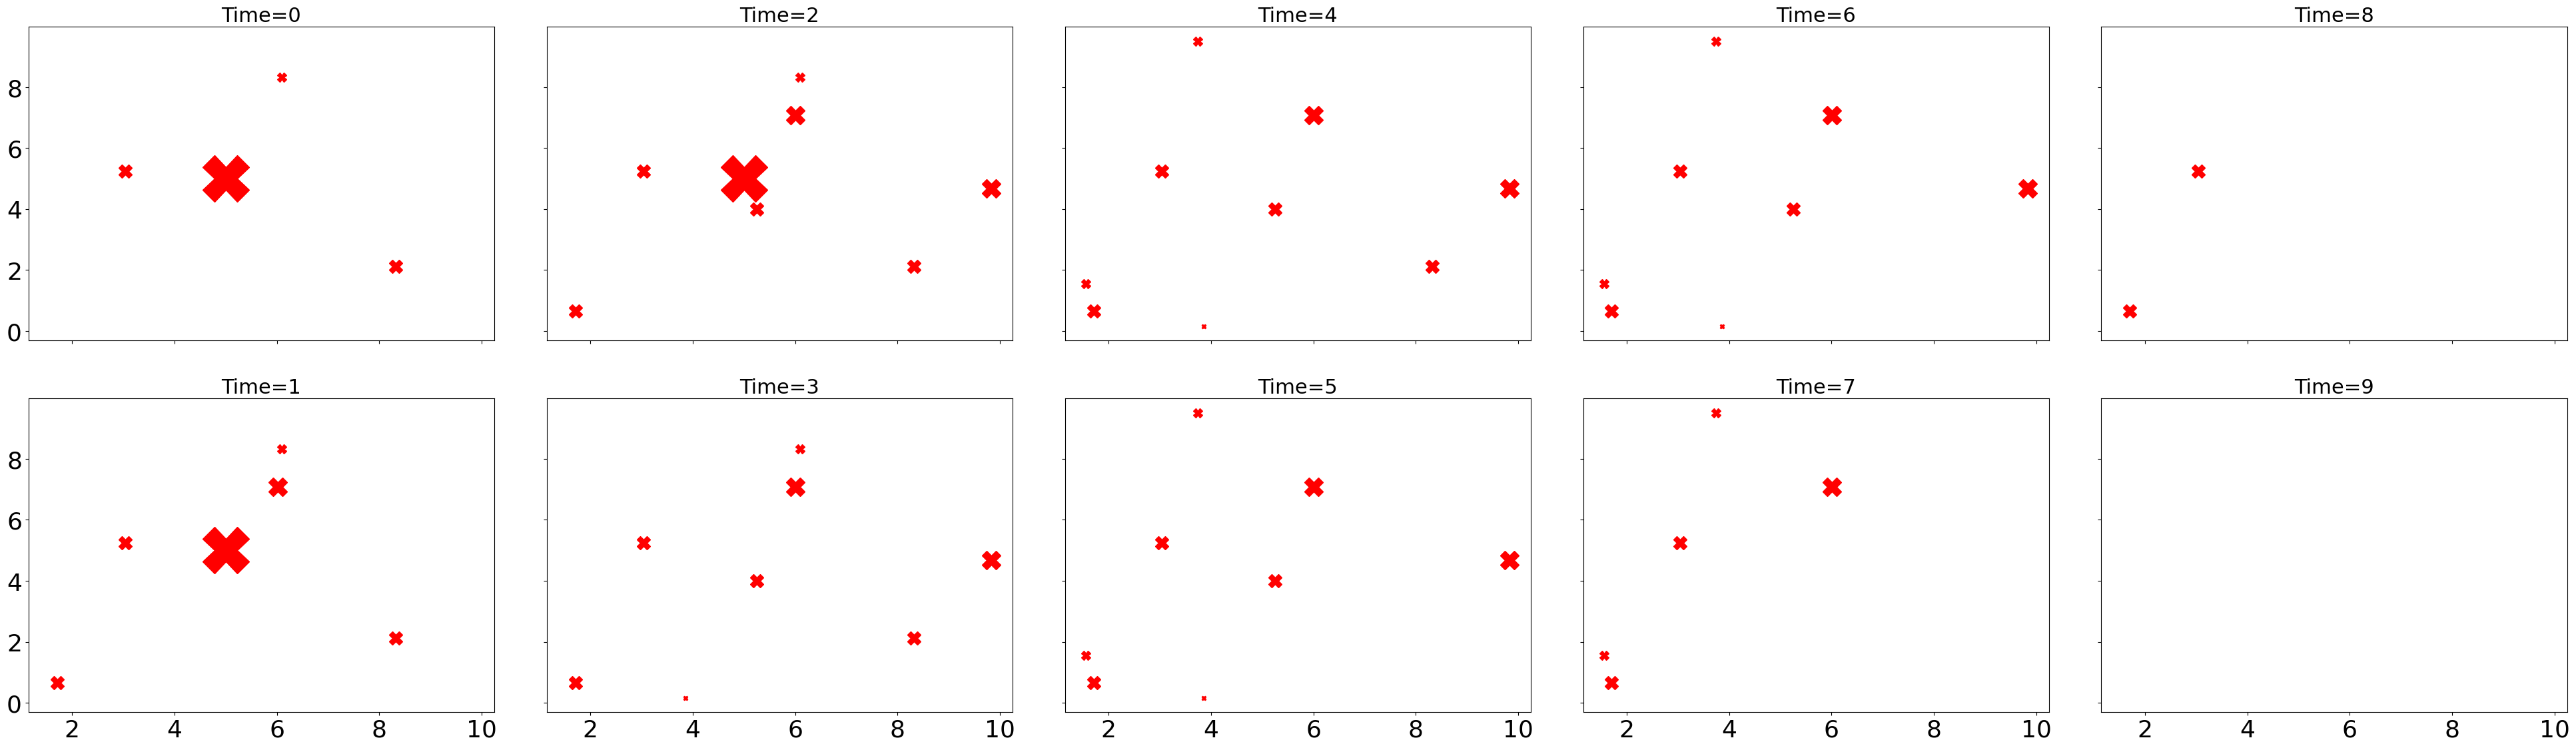

In [5]:
## create snapshot of images
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

#rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

MAX_TIME = 10

DIV = 2
fig,ax = plt.subplots(DIV,MAX_TIME//DIV,figsize=(4*MAX_TIME,DIV*6),sharex=True,sharey=True)

for t in range(0,MAX_TIME):
    cur_event_set = []
    for e in RANDOM_EVENTS:
        if e.happened(t):
            cur_event_set.append(e)
    
    createplot([],cur_event_set,ax[t%DIV][t//DIV],Zoom_Factor=5)
    ax[t%DIV][t//DIV].set_title('Time='+str(t),fontsize=22)

fig.tight_layout()

In [6]:
# ## create snapshot of images
# import seaborn as sns
# import datetime
# from matplotlib import rcParams
# from matplotlib.colors import LinearSegmentedColormap
# import matplotlib.dates as mdates

# #rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 32
# rcParams["axes.labelsize"] = 28
# rcParams["axes.titlesize"] = 28
# rcParams["xtick.labelsize"] = 26
# rcParams["ytick.labelsize"] = 26

# MAX_TIME = 10

# DIV = 2
# fig,ax = plt.subplots(DIV,MAX_TIME//DIV,figsize=(5*MAX_TIME,DIV*10),sharex=True,sharey=True)

# for t in range(0,MAX_TIME):
#     cur_event_set = []
#     for e in CIRCLE_EVENTS:
#         if e.happened(t):
#             cur_event_set.append(e)
    
#     createplot([],cur_event_set,ax[t%DIV][t//DIV],Zoom_Factor=10)
#     ax[t%DIV][t//DIV].set_title('Time='+str(t),fontsize=22)

# fig.tight_layout()

## CREATE AN AGENT



In [7]:
## one agent only
agent_rand_loc = np.random.rand(1,2).flatten()
agent_r = Region(agent_rand_loc[0]*MAX_SCALE,agent_rand_loc[1]*MAX_SCALE)
john = Agent(21,agent_r,1)


## SCENARIO 1: ONLY ONE EVENT
### 1a: only happened at the beginning


In [8]:
ONE_EVENT_WEIGHT = 10
big_event = Event(123,Region(5,5),ONE_EVENT_WEIGHT,TimeInterval(0,0))
ALL_EVENTS = [big_event]

#### visualize event and agent

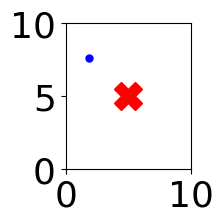

In [10]:
fig,ax = plt.subplots(figsize=(3,3))
createplot([john],ALL_EVENTS,ax)
ax.set_xlim([0,MAX_SCALE])
ax.set_ylim([0,MAX_SCALE])
fig.tight_layout()
fig.savefig('location_one_agent_one_event.pdf',dpi=350)

In [11]:
## different discounting factors
THETAS = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.98,1.0]

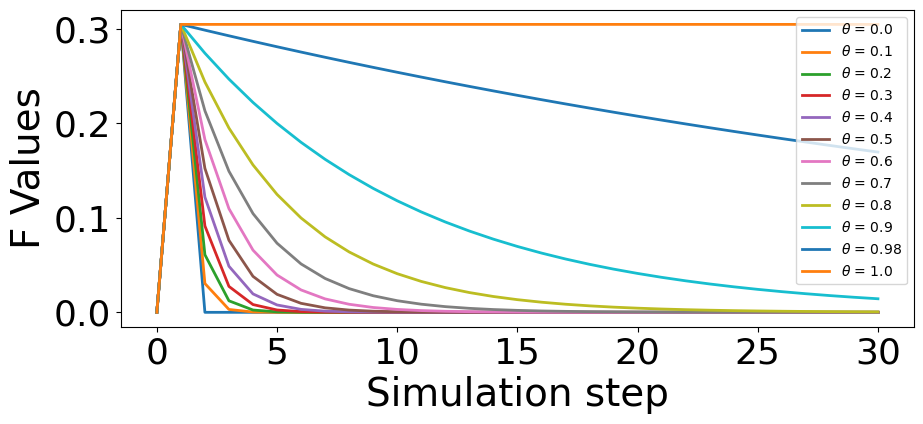

In [12]:
## make agent interact with events


DELTA = 2
SIM_TIME = 30

fig,ax = plt.subplots(figsize=(10,5))

for theta in THETAS:
    john.reset_agent()
    times = []
    fears = []
    intentions = []
    for t in range(0,SIM_TIME):
        times.append(t)
        fears.append(john.fear)
        intentions.append(john.intention)
        cur_event_set = []
        for e in ALL_EVENTS:
            if e.happened(t):
                cur_event_set.append(e)
        risk = riskfunc(john,cur_event_set,DELTA)
        john.update_fear(risk,theta)
    times.append(SIM_TIME)
    fears.append(john.fear)
    intentions.append(john.intention)
    ax.plot(times,fears,label='$\\theta$ = '+str(theta),linewidth=2)
    #ax.plot(times,intentions,label='$\\theta$ = '+str(theta),linewidth=2)

    ax.set(xlabel='Simulation step',ylabel='F Values')
    #ax.set(xlabel='Simulation step',ylabel='Intention')
ax.legend(ncol=1,fontsize=10,loc='best')
#ax.legend(ncol=2,fontsize=14,loc='best')
fig.tight_layout()
fig.savefig('interaction_one_agent_one_event.pdf',dpi=350,bbox_inches='tight')


## 1b. Event happened then continued until some time

In [13]:
ONE_EVENT_WEIGHT = 10
big_event = Event(123,Region(5,5),ONE_EVENT_WEIGHT,TimeInterval(0,5))
ALL_EVENTS = [big_event]

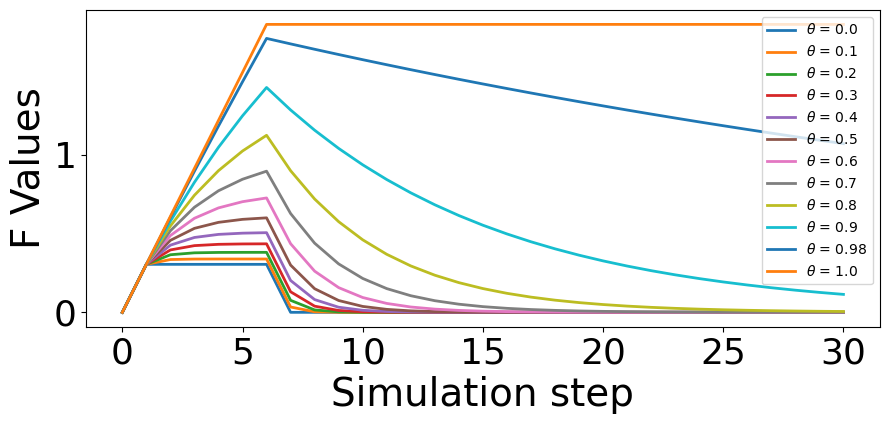

In [14]:
## make agent interact with events
DELTA = 2
SIM_TIME = 30

fig,ax = plt.subplots(figsize=(10,5))

for theta in THETAS:
    john.reset_agent()
    times = []
    fears = []
    intentions = []
    for t in range(0,SIM_TIME):
        times.append(t)
        fears.append(john.fear)
        intentions.append(john.intention)
        cur_event_set = []
        for e in ALL_EVENTS:
            if e.happened(t):
                cur_event_set.append(e)
        risk = riskfunc(john,cur_event_set,DELTA)
        john.update_fear(risk,theta)
    times.append(SIM_TIME)
    fears.append(john.fear)
    intentions.append(john.intention)
    ax.plot(times,fears,label='$\\theta$ = '+str(theta),linewidth=2)
    #ax[1].plot(times,intentions,label='$\\theta$ = '+str(theta),linewidth=2)

    ax.set(xlabel='Simulation step',ylabel='F Values')
    #ax[1].set(xlabel='Simulation step',ylabel='Migration Intention')
ax.legend(ncol=1,fontsize=10,loc='best')
#ax[1].legend(ncol=1,fontsize=14,loc='best')
fig.tight_layout()
fig.savefig('interaction_one_agent_one_event_for_sometime.pdf',dpi=350,bbox_inches='tight')

## Scenario 2: Two events
## 2a: one at first timestep, another some time later, no overlap, both same weight, same location

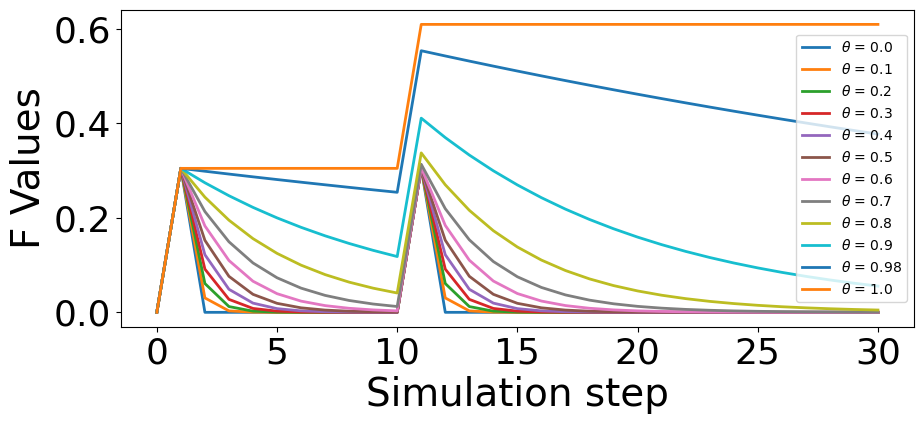

In [15]:
ONE_EVENT_WEIGHT = 10
big_event_1 = Event(123,Region(5,5),ONE_EVENT_WEIGHT,TimeInterval(0,0))
big_event_2 = Event(124,Region(5,5),ONE_EVENT_WEIGHT,TimeInterval(10,10))
ALL_EVENTS = [big_event_1,big_event_2]

## make agent interact with events
DELTA = 2
SIM_TIME = 30

fig,ax = plt.subplots(figsize=(10,5))

for theta in THETAS:
    john.reset_agent()
    times = []
    fears = []
    intentions = []
    for t in range(0,SIM_TIME):
        times.append(t)
        fears.append(john.fear)
        intentions.append(john.intention)
        cur_event_set = []
        for e in ALL_EVENTS:
            if e.happened(t):
                cur_event_set.append(e)
        risk = riskfunc(john,cur_event_set,DELTA)
        john.update_fear(risk,theta)
    times.append(SIM_TIME)
    fears.append(john.fear)
    intentions.append(john.intention)
    ax.plot(times,fears,label='$\\theta$ = '+str(theta),linewidth=2)
    #ax[1].plot(times,intentions,label='$\\theta$ = '+str(theta),linewidth=2)

    ax.set(xlabel='Simulation step',ylabel='F Values')
    #ax[1].set(xlabel='Simulation step',ylabel='Migration Intention')
ax.legend(ncol=1,fontsize=10,loc='best')
#ax[1].legend(ncol=1,fontsize=14,loc='best')
fig.tight_layout()
fig.savefig('interaction_one_agent_two_events.pdf',dpi=350,bbox_inches='tight')

## 2b. second event has half the weight

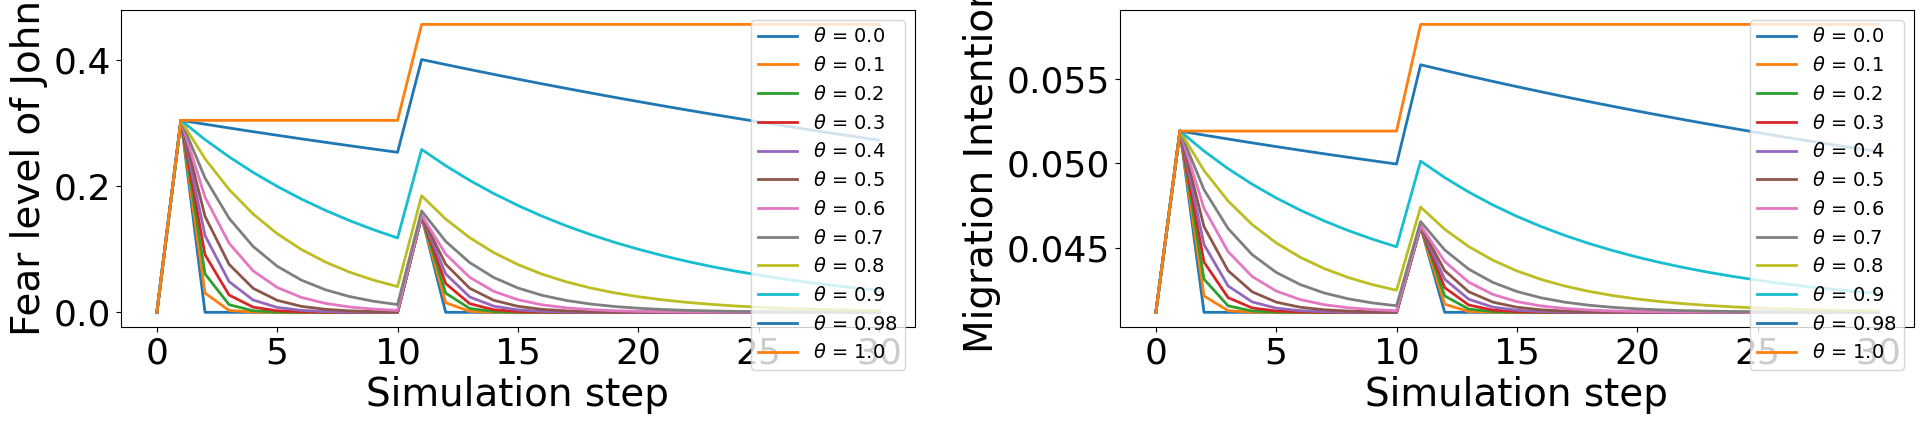

In [16]:
ONE_EVENT_WEIGHT = 10
big_event_1 = Event(123,Region(5,5),ONE_EVENT_WEIGHT,TimeInterval(0,0))
big_event_2 = Event(124,Region(5,5),ONE_EVENT_WEIGHT/2,TimeInterval(10,10))
ALL_EVENTS = [big_event_1,big_event_2]

## make agent interact with events
DELTA = 2
SIM_TIME = 30

fig,ax = plt.subplots(1,2,figsize=(20,5))

for theta in THETAS:
    john.reset_agent()
    times = []
    fears = []
    intentions = []
    for t in range(0,SIM_TIME):
        times.append(t)
        fears.append(john.fear)
        intentions.append(john.intention)
        cur_event_set = []
        for e in ALL_EVENTS:
            if e.happened(t):
                cur_event_set.append(e)
        risk = riskfunc(john,cur_event_set,DELTA)
        john.update_fear(risk,theta)
    times.append(SIM_TIME)
    fears.append(john.fear)
    intentions.append(john.intention)
    ax[0].plot(times,fears,label='$\\theta$ = '+str(theta),linewidth=2)
    ax[1].plot(times,intentions,label='$\\theta$ = '+str(theta),linewidth=2)

    ax[0].set(xlabel='Simulation step',ylabel='Fear level of John')
    ax[1].set(xlabel='Simulation step',ylabel='Migration Intention')
ax[0].legend(ncol=1,fontsize=14,loc='best')
ax[1].legend(ncol=1,fontsize=14,loc='best')
fig.tight_layout()

## Scenario X: MAny events randomly happening


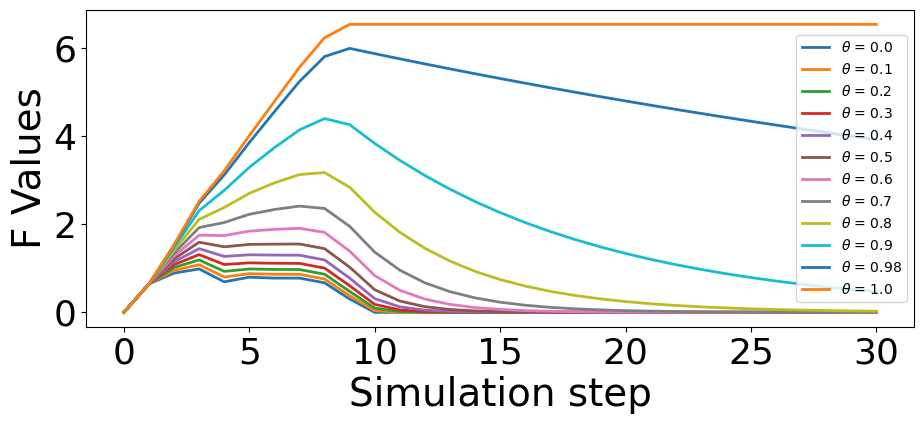

In [17]:
## make agent interact with events
## make agent interact with events
DELTA = 2
SIM_TIME = 30

fig,ax = plt.subplots(figsize=(10,5))

for theta in THETAS:
    john.reset_agent()
    times = []
    fears = []
    intentions = []
    for t in range(0,SIM_TIME):
        times.append(t)
        fears.append(john.fear)
        intentions.append(john.intention)
        cur_event_set = []
        for e in RANDOM_EVENTS:
            if e.happened(t):
                cur_event_set.append(e)
        risk = riskfunc(john,cur_event_set,DELTA)
        john.update_fear(risk,theta)
    times.append(SIM_TIME)
    fears.append(john.fear)
    intentions.append(john.intention)
    ax.plot(times,fears,label='$\\theta$ = '+str(theta),linewidth=2)
    #ax[1].plot(times,intentions,label='$\\theta$ = '+str(theta),linewidth=2)

    ax.set(xlabel='Simulation step',ylabel='F Values')
    #ax[1].set(xlabel='Simulation step',ylabel='Migration Intention')
ax.legend(ncol=1,fontsize=10,loc='best')
#ax[1].legend(ncol=1,fontsize=14,loc='best')
fig.tight_layout()
fig.savefig('interaction_many_events.pdf',dpi=350,bbox_inches='tight')

In [20]:
# import math
# s = 0
# for i in range(2,1000):
#     a = i+11
#     b = math.sqrt(i-1)
#     if int(b)==b:
#         print(i,'valid')
#         if a%(int(b))==0:
#             print(a/b)
#             s = s+i
# print(s)

In [21]:
## relation between theta, delta and time difference between point events
## peak values keep dropping/ rises for what combination?

In [22]:
## create agents:
def create_random_agents(NUM_AGENTS):
    RANDOM_AGENTS = []
    for i in range(0,NUM_AGENTS):
        cur_id = i
        rand_loc = np.random.rand(1,2).flatten()
        agent_rand_loc = np.random.rand(1,2).flatten()
        agent_r = Region(agent_rand_loc[0]*MAX_SCALE,agent_rand_loc[1]*MAX_SCALE)
        john = Agent(cur_id, agent_r,1)
        RANDOM_AGENTS.append(john)
    return RANDOM_AGENTS
NUM_AGENTS = 10
np.random.seed(123)
RANDOM_AGENTS = create_random_agents(NUM_AGENTS)

# PEER EFFECT

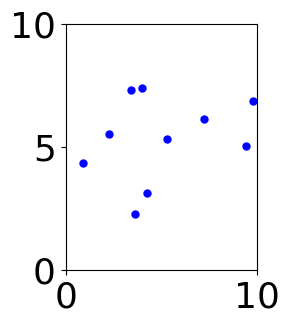

In [22]:
fig,ax = plt.subplots(figsize=(4,4))
createplot(RANDOM_AGENTS,[],ax)
ax.set_xlim([0,MAX_SCALE])
ax.set_ylim([0,MAX_SCALE])
fig.tight_layout()

## define neighbor conditions

### option 1: neighbor creation: a) by distance, b) by probability
### option 2: self loop: a) no self loop, b) allow self loop
### option 3: threshold value: a) number of neighobrs, b) fraction of neighbors

## I have examined the following:
#### A. Neighbor created by distance, no self loop, threshold in terms of number of neighbors
#### B. Neighbor created by distance, self loop, threshold in terms of number of neighbors
#### C. Neighbor created by distance, self loop, threshold in terms of fraction of neighbors
#### D. Neighbor created by prob p, self loop, threshold in terms of fraction of neighbors


### A

#### Parameters: P, T
#### P: neighbors have an edge with prob (1/dis)^P, lower P -> more edges (P>1.0)
#### T: num of neighbors needed to drive somebody to leave, lower T -> more people leave

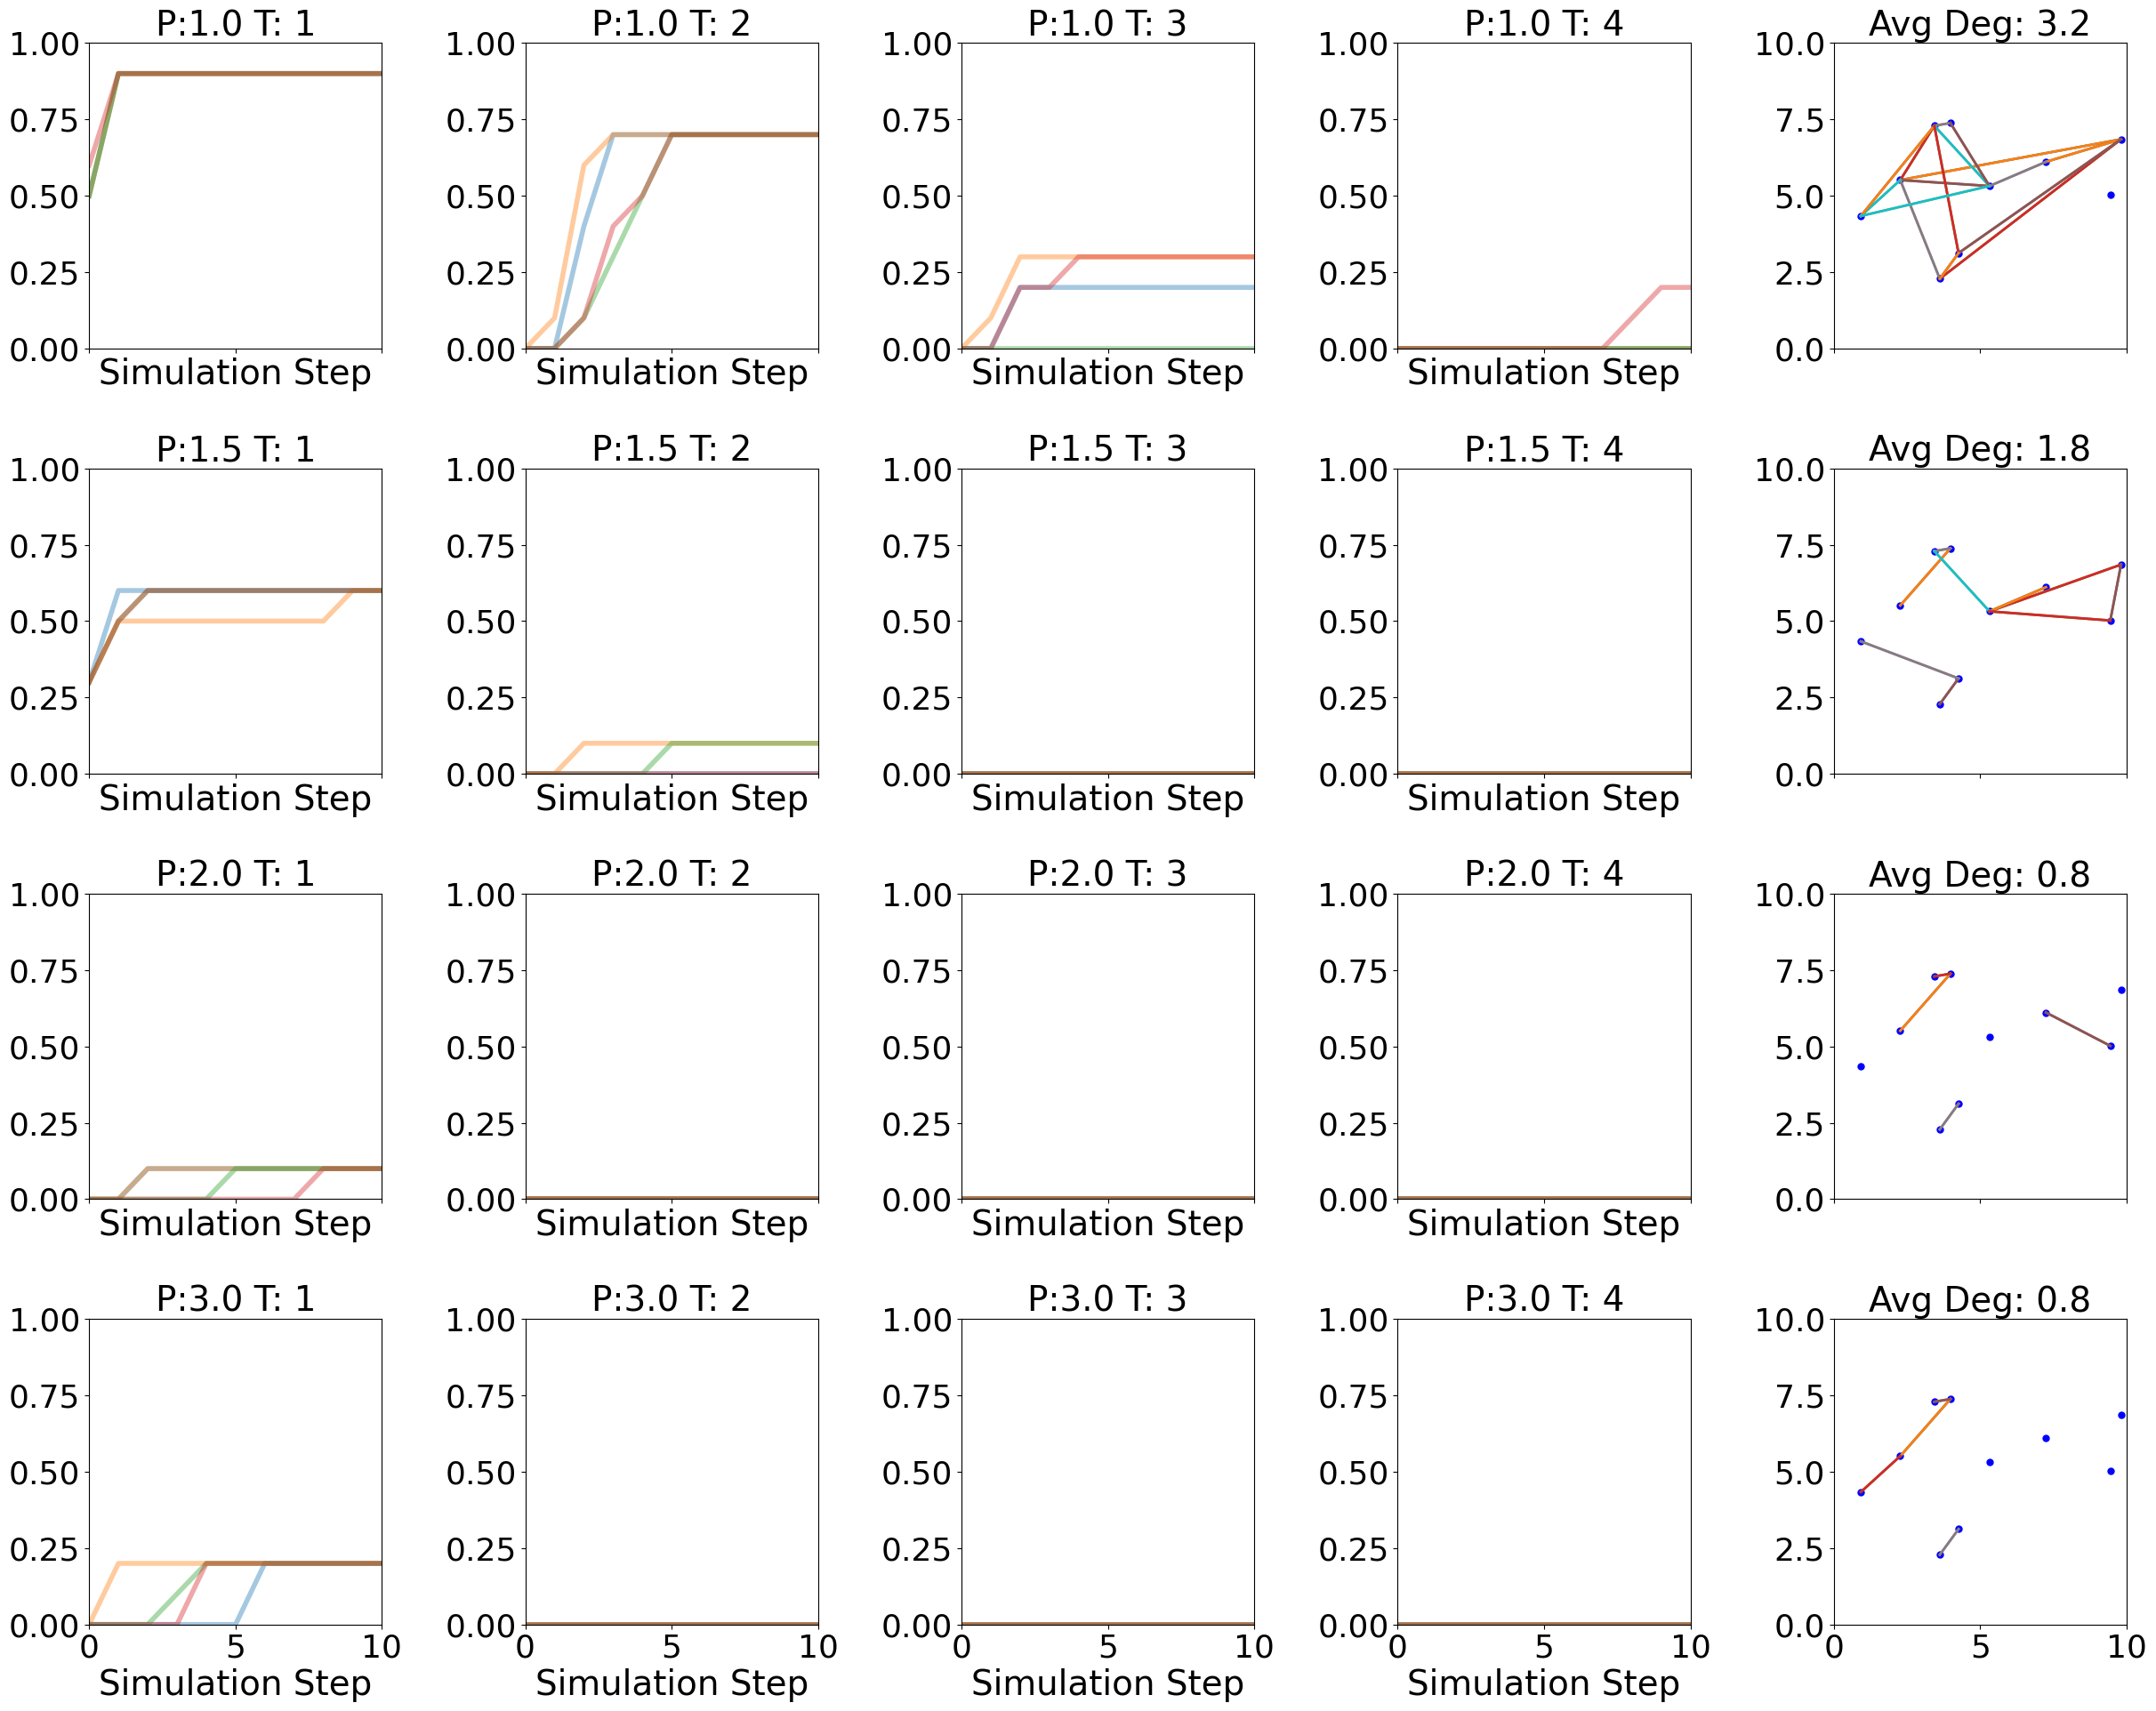

In [23]:


import random

random.seed(123)
np.random.seed(42)
#P = 2 #from 1 to 10??

all_neighbors = []

def calc_average_degree(num_agents):
    agent_degrees = []
    for i in range(0,num_agents):
        agent_degrees.append(0)
    for i in range(len(all_neighbors)):
        agent_degrees[all_neighbors[i][0].id] = agent_degrees[all_neighbors[i][0].id]+1
        agent_degrees[all_neighbors[i][1].id] = agent_degrees[all_neighbors[i][1].id]+1
    ss = 0.0
    for i in range(0,num_agents):
        agent_degrees[i] = agent_degrees[i]/2
        ss = ss + agent_degrees[i]
    return ss/num_agents
        

def create_neighbors(agent_a,agent_b,P):
    D = (agent_a.region).dis(agent_b.region)
    q = random.uniform(0,1)
    if q<=(1.0/(D**P+EPS)):
        all_neighbors.append([agent_a,agent_b])
        if agent_a.id!=agent_b.id:
            all_neighbors.append([agent_b,agent_a])
    return


def isneighbor(agent_a,agent_b):
    return [agent_a,agent_b] in all_neighbors

# for a in RANDOM_AGENTS:
#     print(a,john,isneighbor(a,john))

THRESH = 3
SIM_TIME = 30
THETA = 0.9
#update_migration_from_peer

grid = 4

fig,ax = plt.subplots(grid,grid+1,figsize=(5*grid+5,5*grid),sharex=True)


for pidx, P in enumerate([1.0,1.5,2.0,3.0]):
    
    all_neighbors = []
        
    for i in range(0,len(RANDOM_AGENTS)):
        for j in range(i+1,len(RANDOM_AGENTS)):
            create_neighbors(RANDOM_AGENTS[i],RANDOM_AGENTS[j],P)
    
    createplot(RANDOM_AGENTS,[],ax[pidx][grid])
    ax[pidx][grid].set_xlim([0,MAX_SCALE])
    ax[pidx][grid].set_ylim([0,MAX_SCALE])
    
    for i in range(0,len(all_neighbors)):
        ax[pidx][grid].plot([all_neighbors[i][0].region.x,all_neighbors[i][1].region.x],[all_neighbors[i][0].region.y,all_neighbors[i][1].region.y],linewidth=2)
    
    ax[pidx][grid].set(title='Avg Deg: '+str(calc_average_degree(NUM_AGENTS)))
    
    for tidx, THRESH in enumerate([1,2,3,4]):
        
        for scenario_idx in range(0,4):
            
            RANDOM_EVENTS = create_random_events(10)
            
            ts = []
            people_migrated = []

            for agent in RANDOM_AGENTS:
                agent.reset_agent()


            for t in range(0,SIM_TIME):

                #print("\nAt time ",t)
                for john in RANDOM_AGENTS:
                    cur_event_set = []
                    for e in RANDOM_EVENTS:
                        if e.happened(t):
                            cur_event_set.append(e)
                    risk = riskfunc(john,cur_event_set,DELTA)
                    john.update_fear(risk,THETA)

                neighbor_intentions = []
                ##synchronous, so everyone updates after interaction
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'before peer interaction')
                    neighbor_effect = 0
                    for j in range(0,len(RANDOM_AGENTS)):
                        if i==j:
                            continue
                        next_agent = RANDOM_AGENTS[j]
                        if isneighbor(cur_agent,next_agent):
                            neighbor_effect = neighbor_effect+max(next_agent.intention,next_agent.migration)
                    neighbor_intentions.append(neighbor_effect)

                ##update
                #print('')
                migrated = 0
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    cur_agent.update_migration_from_peer(neighbor_intentions[i],THRESH)
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'after peer interaction')
                    migrated = migrated + cur_agent.migration

                ts.append(t)
                people_migrated.append(migrated)

            #print(len(ts))
            #print(len(ps))
            #print(len(ts),len(people_migrated),pidx,tidx)
            for i in range(len(people_migrated)):
                people_migrated[i] = people_migrated[i]/len(RANDOM_AGENTS)
            ax[pidx][tidx].plot(ts,people_migrated,linewidth=4,alpha=0.4)
            ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            ax[pidx][tidx].set_xlabel('Simulation Step')
            ax[pidx][tidx].set_ylim([0,1])
            ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=4,label='S-'+str(scenario_idx),alpha=0.3)
            # ax[pidx][tidx].set(title='P:'+str(P)+" Threshold: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,None])
            # ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].legend(loc='best',fontsize=10)

fig.tight_layout()

### B

#### Parameters: P, T
#### P: neighbors have an edge with prob (1/dis)^P, lower P -> more edges (P>1.0)
#### T: num of neighbors needed to drive somebody to leave, lower T -> more people leave

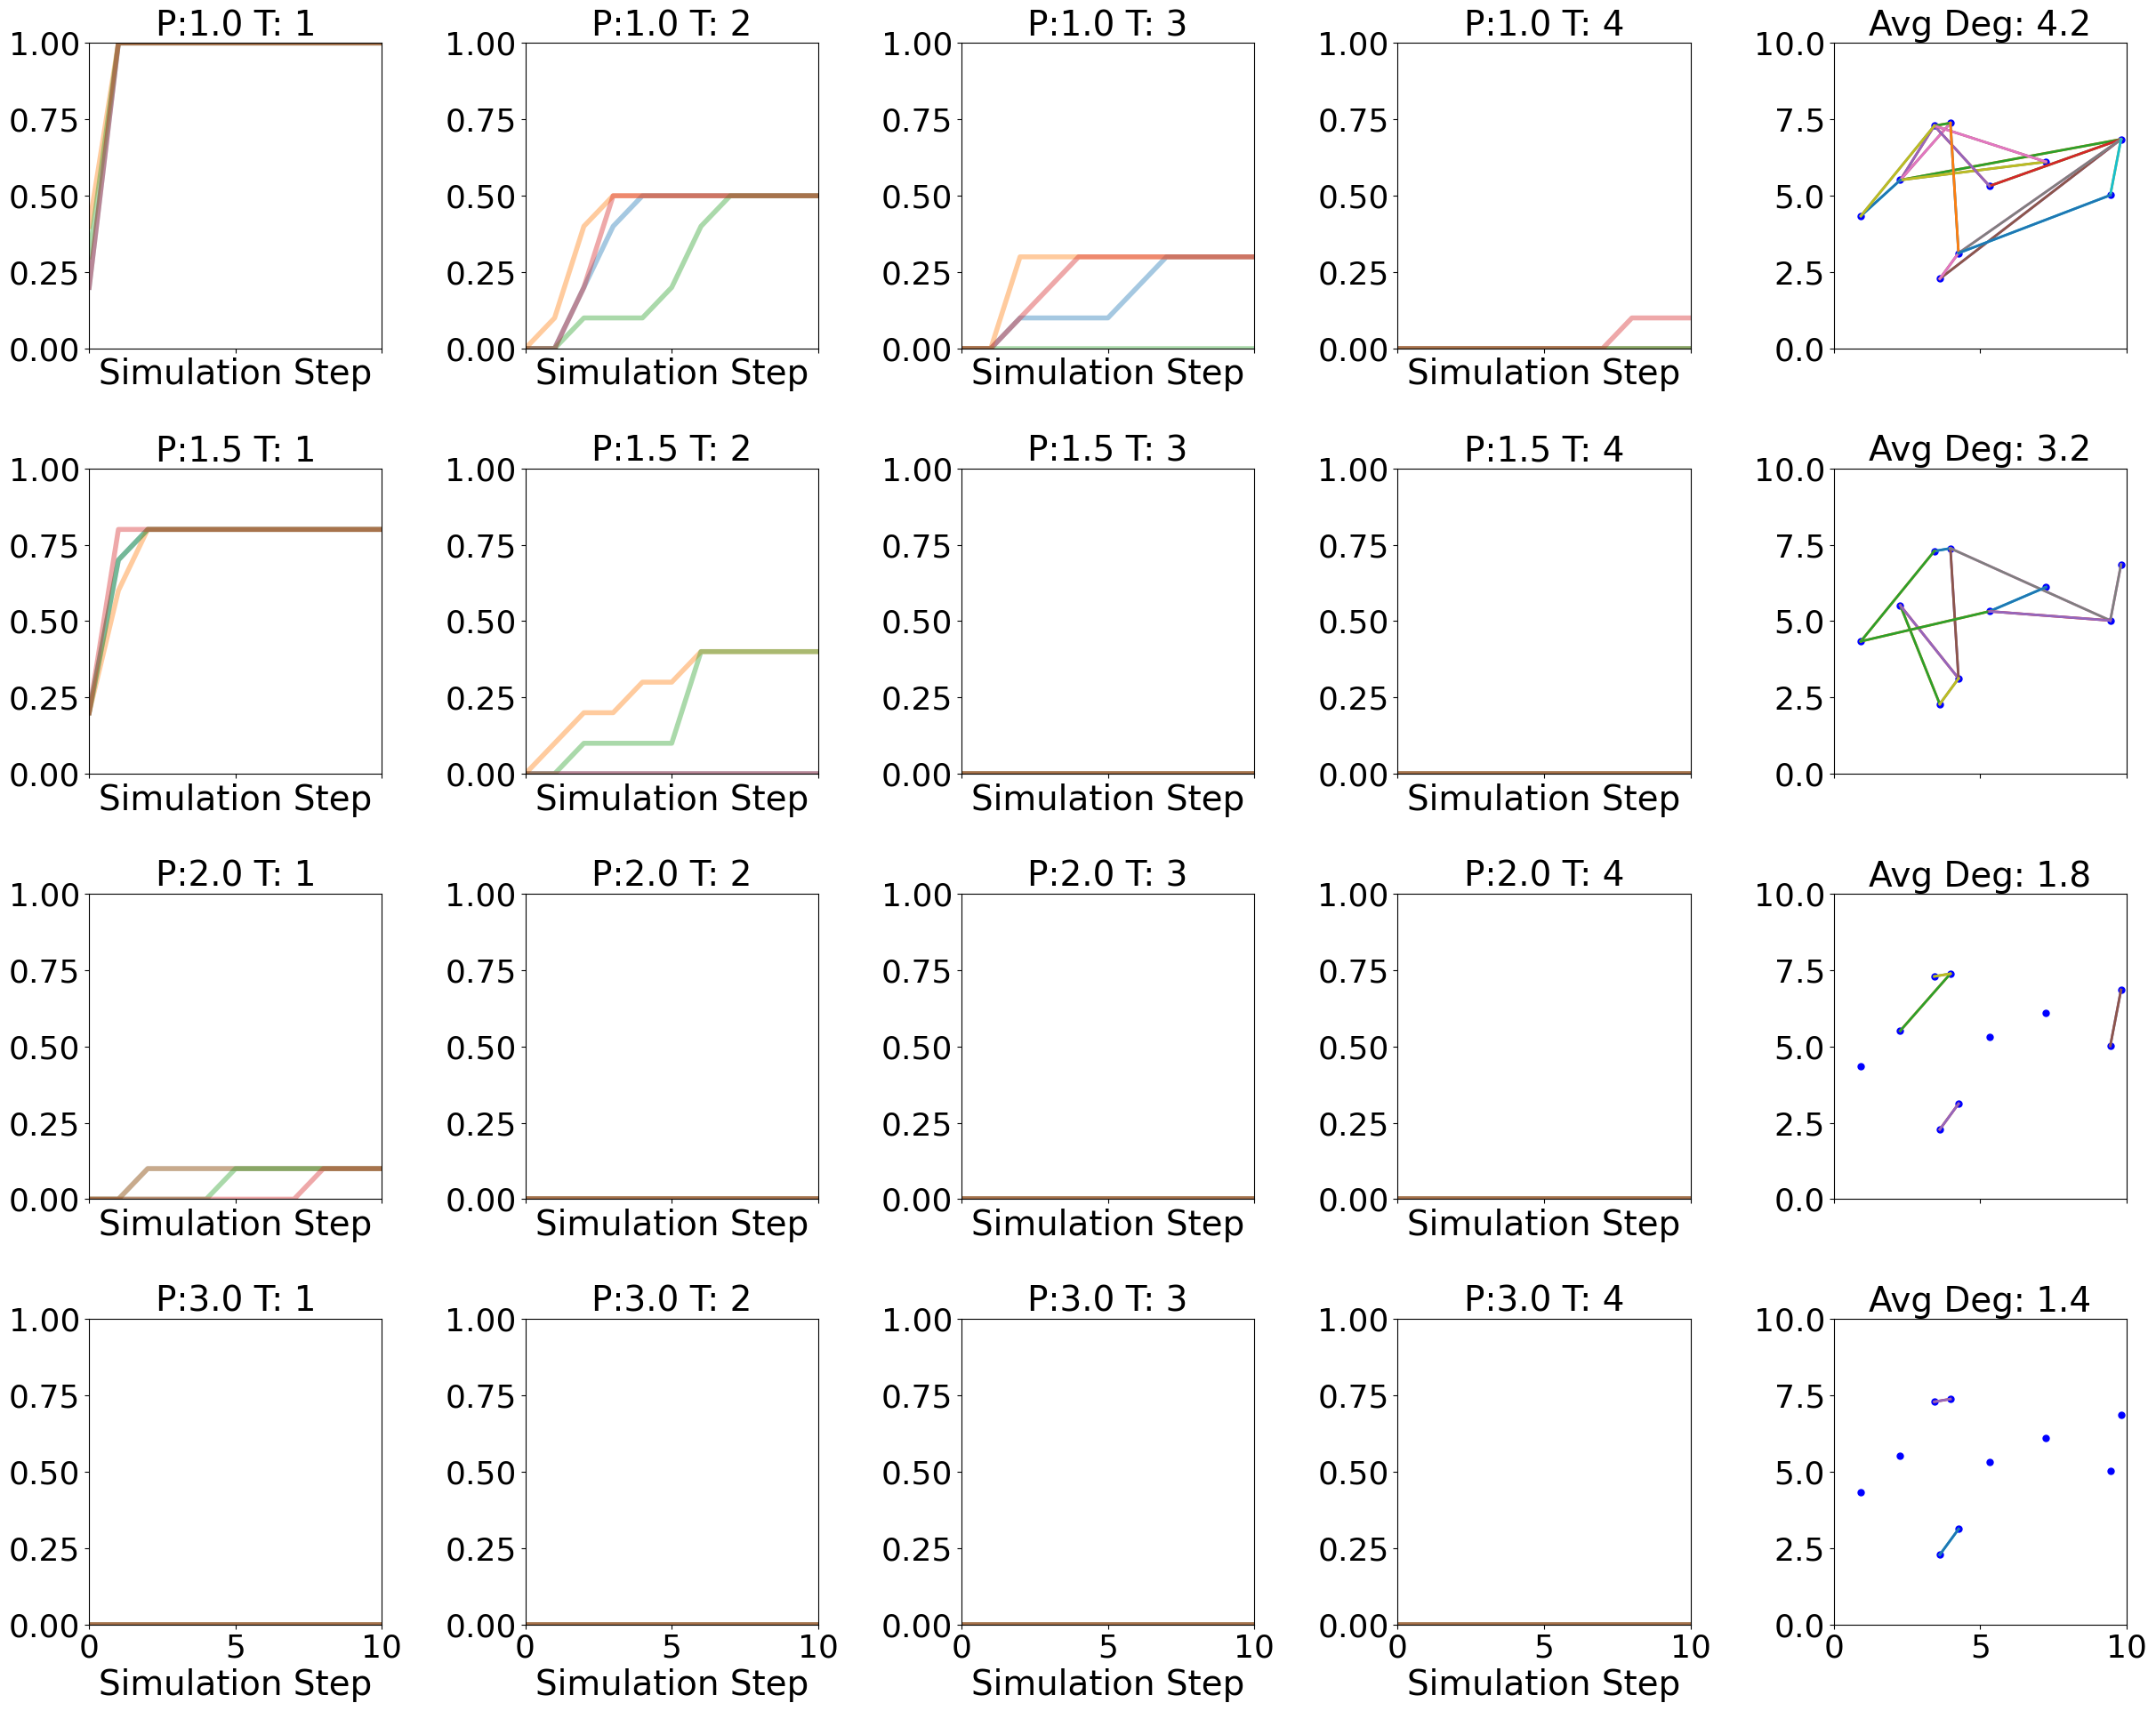

In [24]:


import random

random.seed(123)
np.random.seed(42)

#P = 2 #from 1 to 10??

all_neighbors = []

def calc_average_degree(num_agents):
    agent_degrees = []
    for i in range(0,num_agents):
        agent_degrees.append(0)
    for i in range(len(all_neighbors)):
        agent_degrees[all_neighbors[i][0].id] = agent_degrees[all_neighbors[i][0].id]+1
        agent_degrees[all_neighbors[i][1].id] = agent_degrees[all_neighbors[i][1].id]+1
    ss = 0.0
    for i in range(0,num_agents):
        agent_degrees[i] = agent_degrees[i]/2
        ss = ss + agent_degrees[i]
    return ss/num_agents

def create_neighbors(agent_a,agent_b,P):
    D = (agent_a.region).dis(agent_b.region)
    q = random.uniform(0,1)
    if q<=(1.0/(D**P+EPS)):
        all_neighbors.append([agent_a,agent_b])
        if agent_a.id!=agent_b.id:
            all_neighbors.append([agent_b,agent_a])
    return


def isneighbor(agent_a,agent_b):
    return [agent_a,agent_b] in all_neighbors

# for a in RANDOM_AGENTS:
#     print(a,john,isneighbor(a,john))

THRESH = 3
SIM_TIME = 30
THETA = 0.9
#update_migration_from_peer

grid = 4

fig,ax = plt.subplots(grid,grid+1,figsize=(5*grid+5,5*grid),sharex=True)


for pidx, P in enumerate([1.0,1.5,2.0,3.0]):
    
    all_neighbors = []
        
    for i in range(0,len(RANDOM_AGENTS)):
        for j in range(i,len(RANDOM_AGENTS)):
            create_neighbors(RANDOM_AGENTS[i],RANDOM_AGENTS[j],P)
    
    createplot(RANDOM_AGENTS,[],ax[pidx][grid])
    ax[pidx][grid].set_xlim([0,MAX_SCALE])
    ax[pidx][grid].set_ylim([0,MAX_SCALE])
    
    for i in range(0,len(all_neighbors)):
        ax[pidx][grid].plot([all_neighbors[i][0].region.x,all_neighbors[i][1].region.x],[all_neighbors[i][0].region.y,all_neighbors[i][1].region.y],linewidth=2)
    
    ax[pidx][grid].set(title='Avg Deg: '+str(calc_average_degree(NUM_AGENTS)))
    
    for tidx, THRESH in enumerate([1,2,3,4]):
        
        for scenario_idx in range(0,4):
            
            RANDOM_EVENTS = create_random_events(10)
        
            ts = []
            people_migrated = []

            for agent in RANDOM_AGENTS:
                agent.reset_agent()

            for t in range(0,SIM_TIME):

                #print("\nAt time ",t)
                for john in RANDOM_AGENTS:
                    cur_event_set = []
                    for e in RANDOM_EVENTS:
                        if e.happened(t):
                            cur_event_set.append(e)
                    risk = riskfunc(john,cur_event_set,DELTA)
                    john.update_fear(risk,THETA)

                neighbor_intentions = []
                ##synchronous, so everyone updates after interaction
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'before peer interaction')
                    neighbor_effect = 0
                    for j in range(0,len(RANDOM_AGENTS)):
                        if i==j:
                            continue
                        next_agent = RANDOM_AGENTS[j]
                        if isneighbor(cur_agent,next_agent):
                            neighbor_effect = neighbor_effect+max(next_agent.intention,next_agent.migration)
                    neighbor_intentions.append(neighbor_effect)

                ##update
                #print('')
                migrated = 0
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    cur_agent.update_migration_from_peer(neighbor_intentions[i],THRESH)
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'after peer interaction')
                    migrated = migrated + cur_agent.migration

                ts.append(t)
                people_migrated.append(migrated)

            #print(len(ts))
            #print(len(ps))
            #print(len(ts),len(people_migrated),pidx,tidx)
            for i in range(len(people_migrated)):
                people_migrated[i] = people_migrated[i]/len(RANDOM_AGENTS)
            ax[pidx][tidx].plot(ts,people_migrated,linewidth=4,alpha=0.4)
            ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            ax[pidx][tidx].set_xlabel('Simulation Step')
            ax[pidx][tidx].set_ylim([0,1])
            ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=2,label='S-'+str(scenario_idx),alpha=0.3)
            # ax[pidx][tidx].set(title='P:'+str(P)+" Threshold: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,None])
            # ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].legend(loc='best',fontsize=12)

fig.tight_layout()
plt.show()

### C

#### Parameters: P, T
#### P: neighbors have an edge with prob (1/dis)^P, lower P -> more edges (P>1.0)
#### T: fraction of neighbors needed to drive somebody to leave, lower T -> more people leave

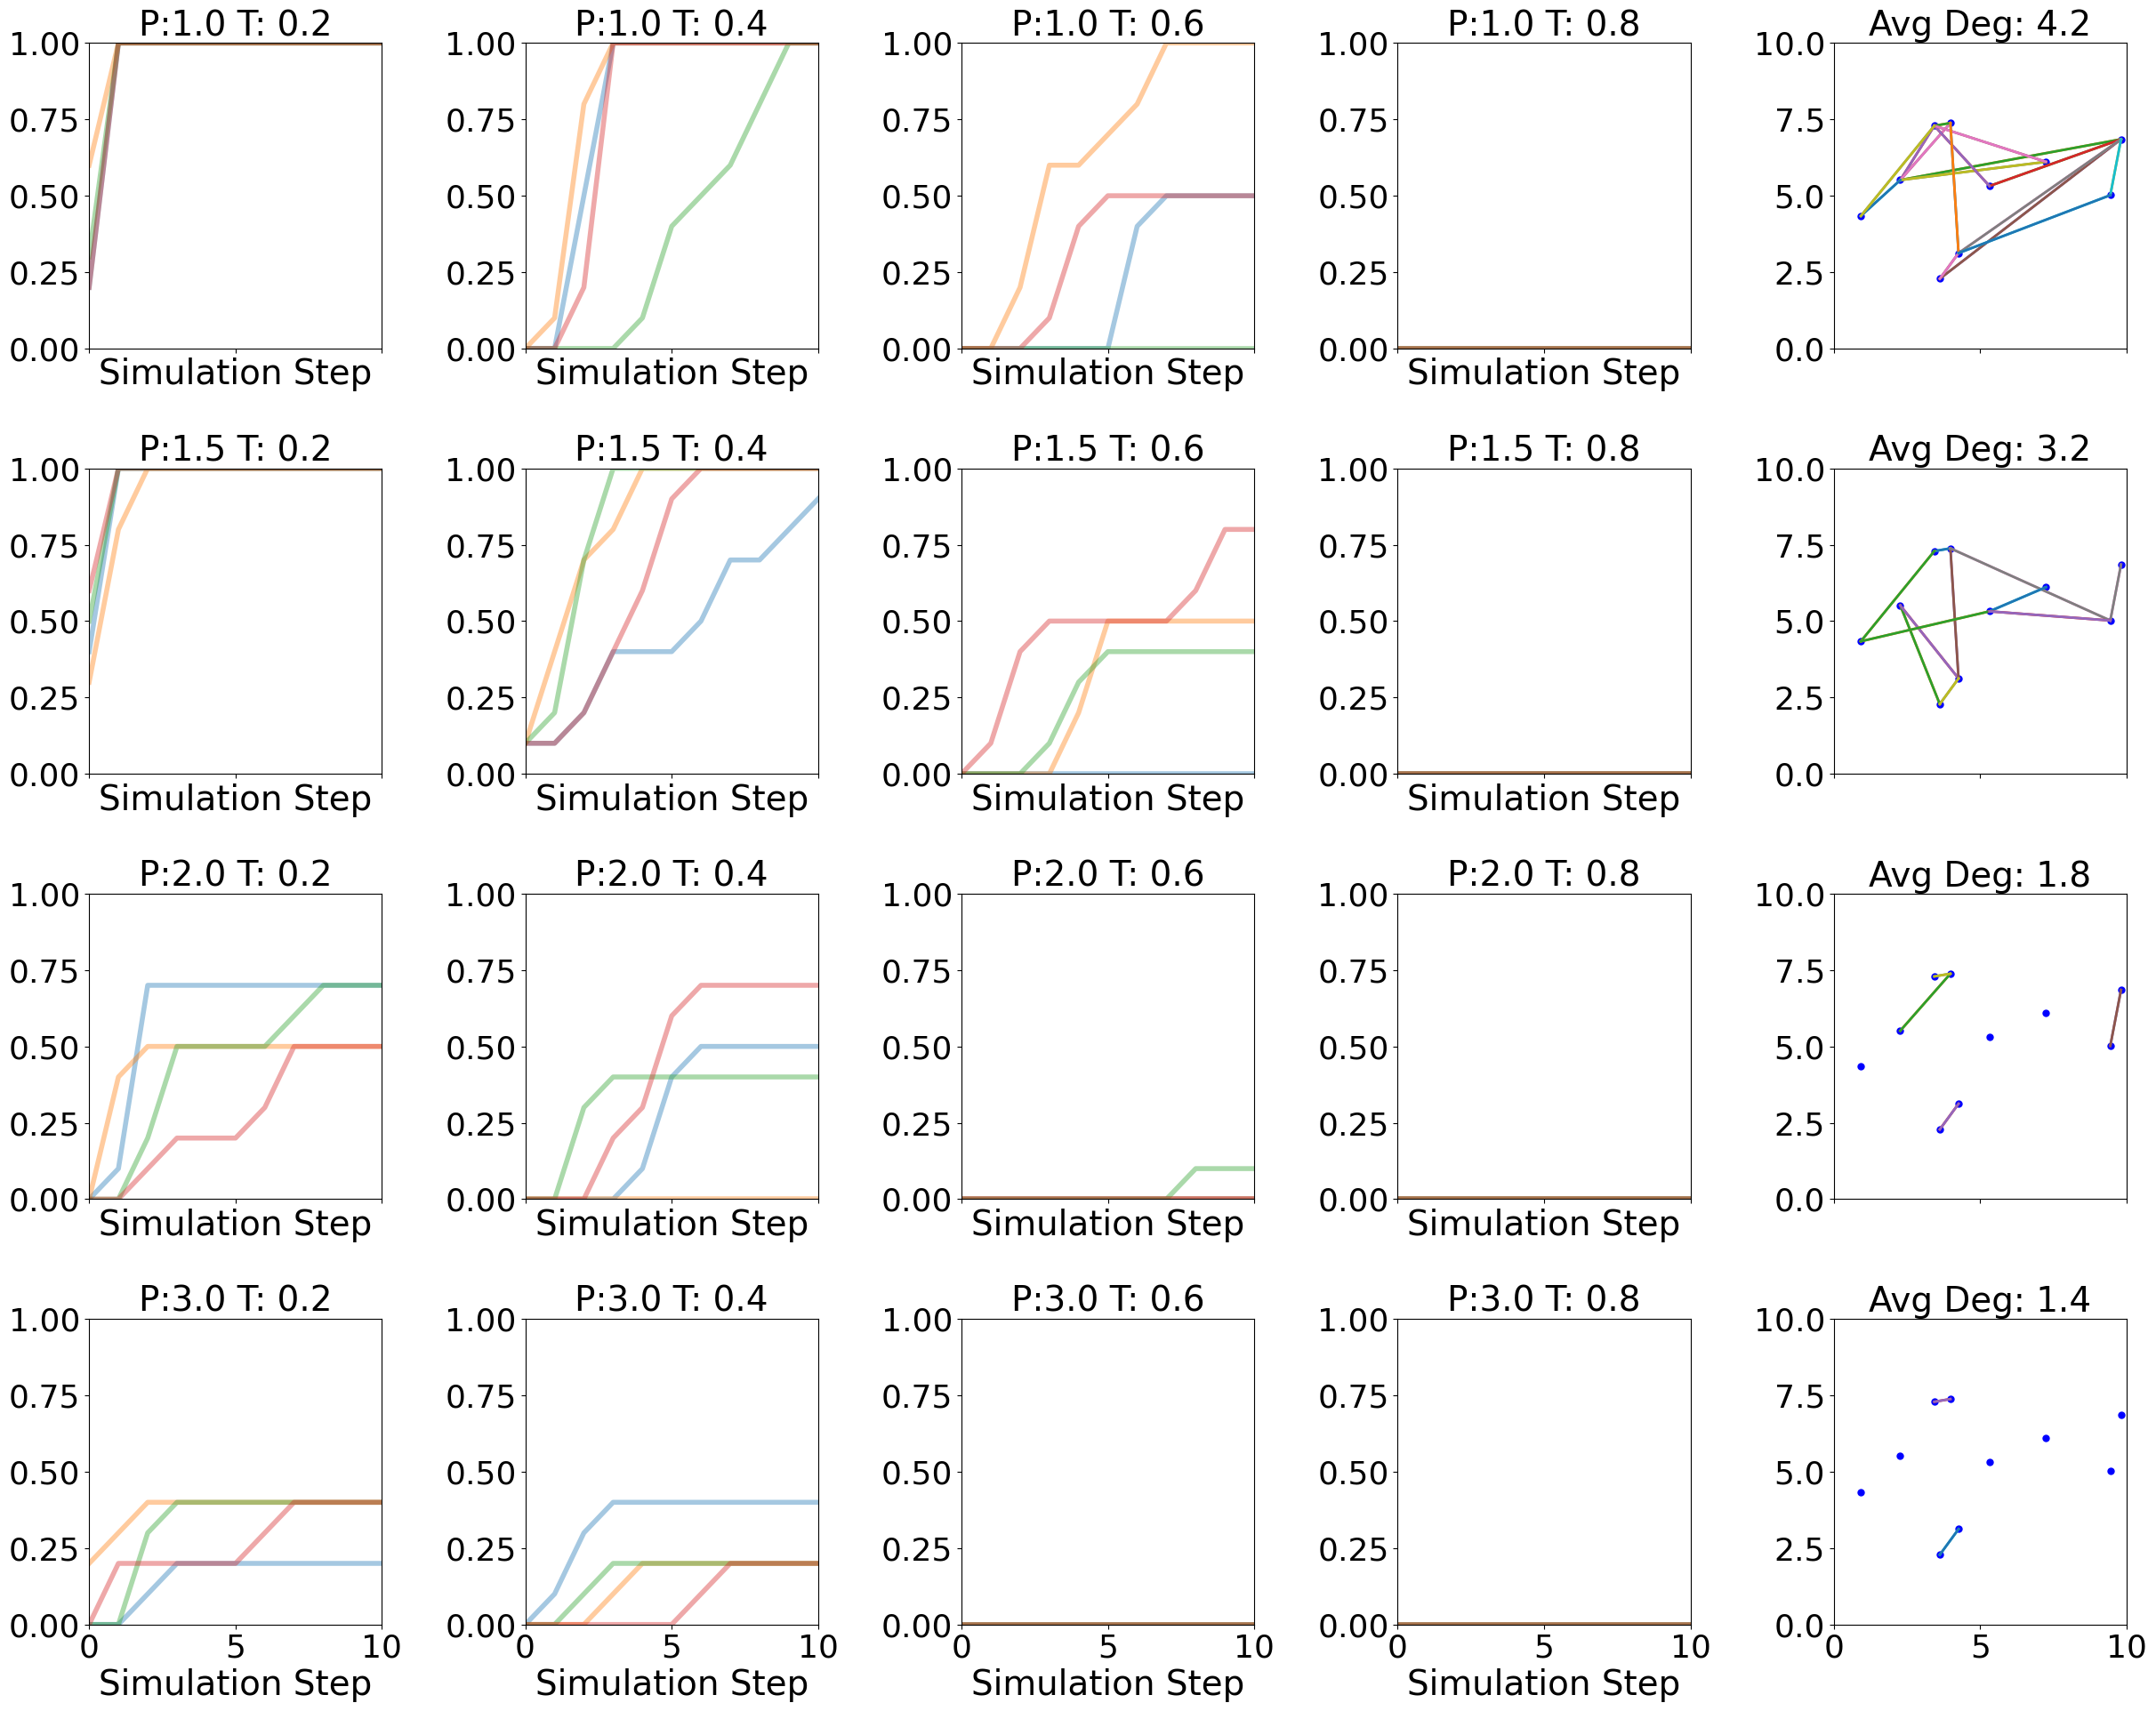

In [25]:


import random

random.seed(123)
np.random.seed(42)

#P = 2 #from 1 to 10??

all_neighbors = []

def calc_average_degree(num_agents):
    agent_degrees = []
    for i in range(0,num_agents):
        agent_degrees.append(0)
    for i in range(len(all_neighbors)):
        agent_degrees[all_neighbors[i][0].id] = agent_degrees[all_neighbors[i][0].id]+1
        agent_degrees[all_neighbors[i][1].id] = agent_degrees[all_neighbors[i][1].id]+1
    ss = 0.0
    for i in range(0,num_agents):
        agent_degrees[i] = agent_degrees[i]/2
        ss = ss + agent_degrees[i]
    return ss/num_agents

def create_neighbors(agent_a,agent_b,P):
    D = (agent_a.region).dis(agent_b.region)
    q = random.uniform(0,1)
    if q<=(1.0/(D**P+EPS)):
        all_neighbors.append([agent_a,agent_b])
        if agent_a.id!=agent_b.id:
            all_neighbors.append([agent_b,agent_a])
    return


def isneighbor(agent_a,agent_b):
    return [agent_a,agent_b] in all_neighbors

# for a in RANDOM_AGENTS:
#     print(a,john,isneighbor(a,john))

THRESH = 3
SIM_TIME = 30
THETA = 0.9
#update_migration_from_peer

grid = 4

fig,ax = plt.subplots(grid,grid+1,figsize=(5*grid+5,5*grid),sharex=True)


for pidx, P in enumerate([1.0,1.5,2.0,3.0]):
    
    all_neighbors = []
        
    for i in range(0,len(RANDOM_AGENTS)):
        for j in range(i,len(RANDOM_AGENTS)):
            create_neighbors(RANDOM_AGENTS[i],RANDOM_AGENTS[j],P)
    
    createplot(RANDOM_AGENTS,[],ax[pidx][grid])
    ax[pidx][grid].set_xlim([0,MAX_SCALE])
    ax[pidx][grid].set_ylim([0,MAX_SCALE])
    
    for i in range(0,len(all_neighbors)):
        ax[pidx][grid].plot([all_neighbors[i][0].region.x,all_neighbors[i][1].region.x],[all_neighbors[i][0].region.y,all_neighbors[i][1].region.y],linewidth=2)
     
    ax[pidx][grid].set(title='Avg Deg: '+str(calc_average_degree(NUM_AGENTS)))
    
    for tidx, THRESH in enumerate([0.2,0.4,0.6,0.8]):
        
        for scenario_idx in range(0,4):
            
            RANDOM_EVENTS = create_random_events(10)
        
            ts = []
            people_migrated = []

            for agent in RANDOM_AGENTS:
                agent.reset_agent()

            for t in range(0,SIM_TIME):

                #print("\nAt time ",t)
                for john in RANDOM_AGENTS:
                    cur_event_set = []
                    for e in RANDOM_EVENTS:
                        if e.happened(t):
                            cur_event_set.append(e)
                    risk = riskfunc(john,cur_event_set,DELTA)
                    john.update_fear(risk,THETA)

                neighbor_intentions = []
                neighbor_sizes = []
                ##synchronous, so everyone updates after interaction
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'before peer interaction')
                    neighbor_effect = 0
                    tot_neighbor = 1
                    for j in range(0,len(RANDOM_AGENTS)):
                        if i==j:
                            continue
                        next_agent = RANDOM_AGENTS[j]
                        if isneighbor(cur_agent,next_agent):
                            neighbor_effect = neighbor_effect+max(next_agent.intention,next_agent.migration)
                            tot_neighbor = tot_neighbor + 1
                    neighbor_intentions.append(neighbor_effect)
                    neighbor_sizes.append(tot_neighbor)

                ##update
                #print('')
                migrated = 0
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    cur_agent.update_migration_from_peer(neighbor_intentions[i]/neighbor_sizes[i],THRESH)
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'after peer interaction')
                    migrated = migrated + cur_agent.migration

                ts.append(t)
                people_migrated.append(migrated)

            #print(len(ts))
            #print(len(ps))
            #print(len(ts),len(people_migrated),pidx,tidx)
            for i in range(len(people_migrated)):
                people_migrated[i] = people_migrated[i]/len(RANDOM_AGENTS)
            ax[pidx][tidx].plot(ts,people_migrated,linewidth=4,alpha=0.4)
            ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            ax[pidx][tidx].set_xlabel('Simulation Step')
            ax[pidx][tidx].set_ylim([0,1])
            ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=2,label='S-'+str(scenario_idx),alpha=0.4)
            # ax[pidx][tidx].set(title='P:'+str(P)+" Threshold: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,None])
            # ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].legend(loc='best',fontsize=12)

fig.tight_layout()
plt.show()

### D

#### Parameters: P, T
#### P: neighbors have an edge with prob P, higher P -> more edges
#### T: fraction of neighbors needed to drive somebody to leave, lower T -> more people leave

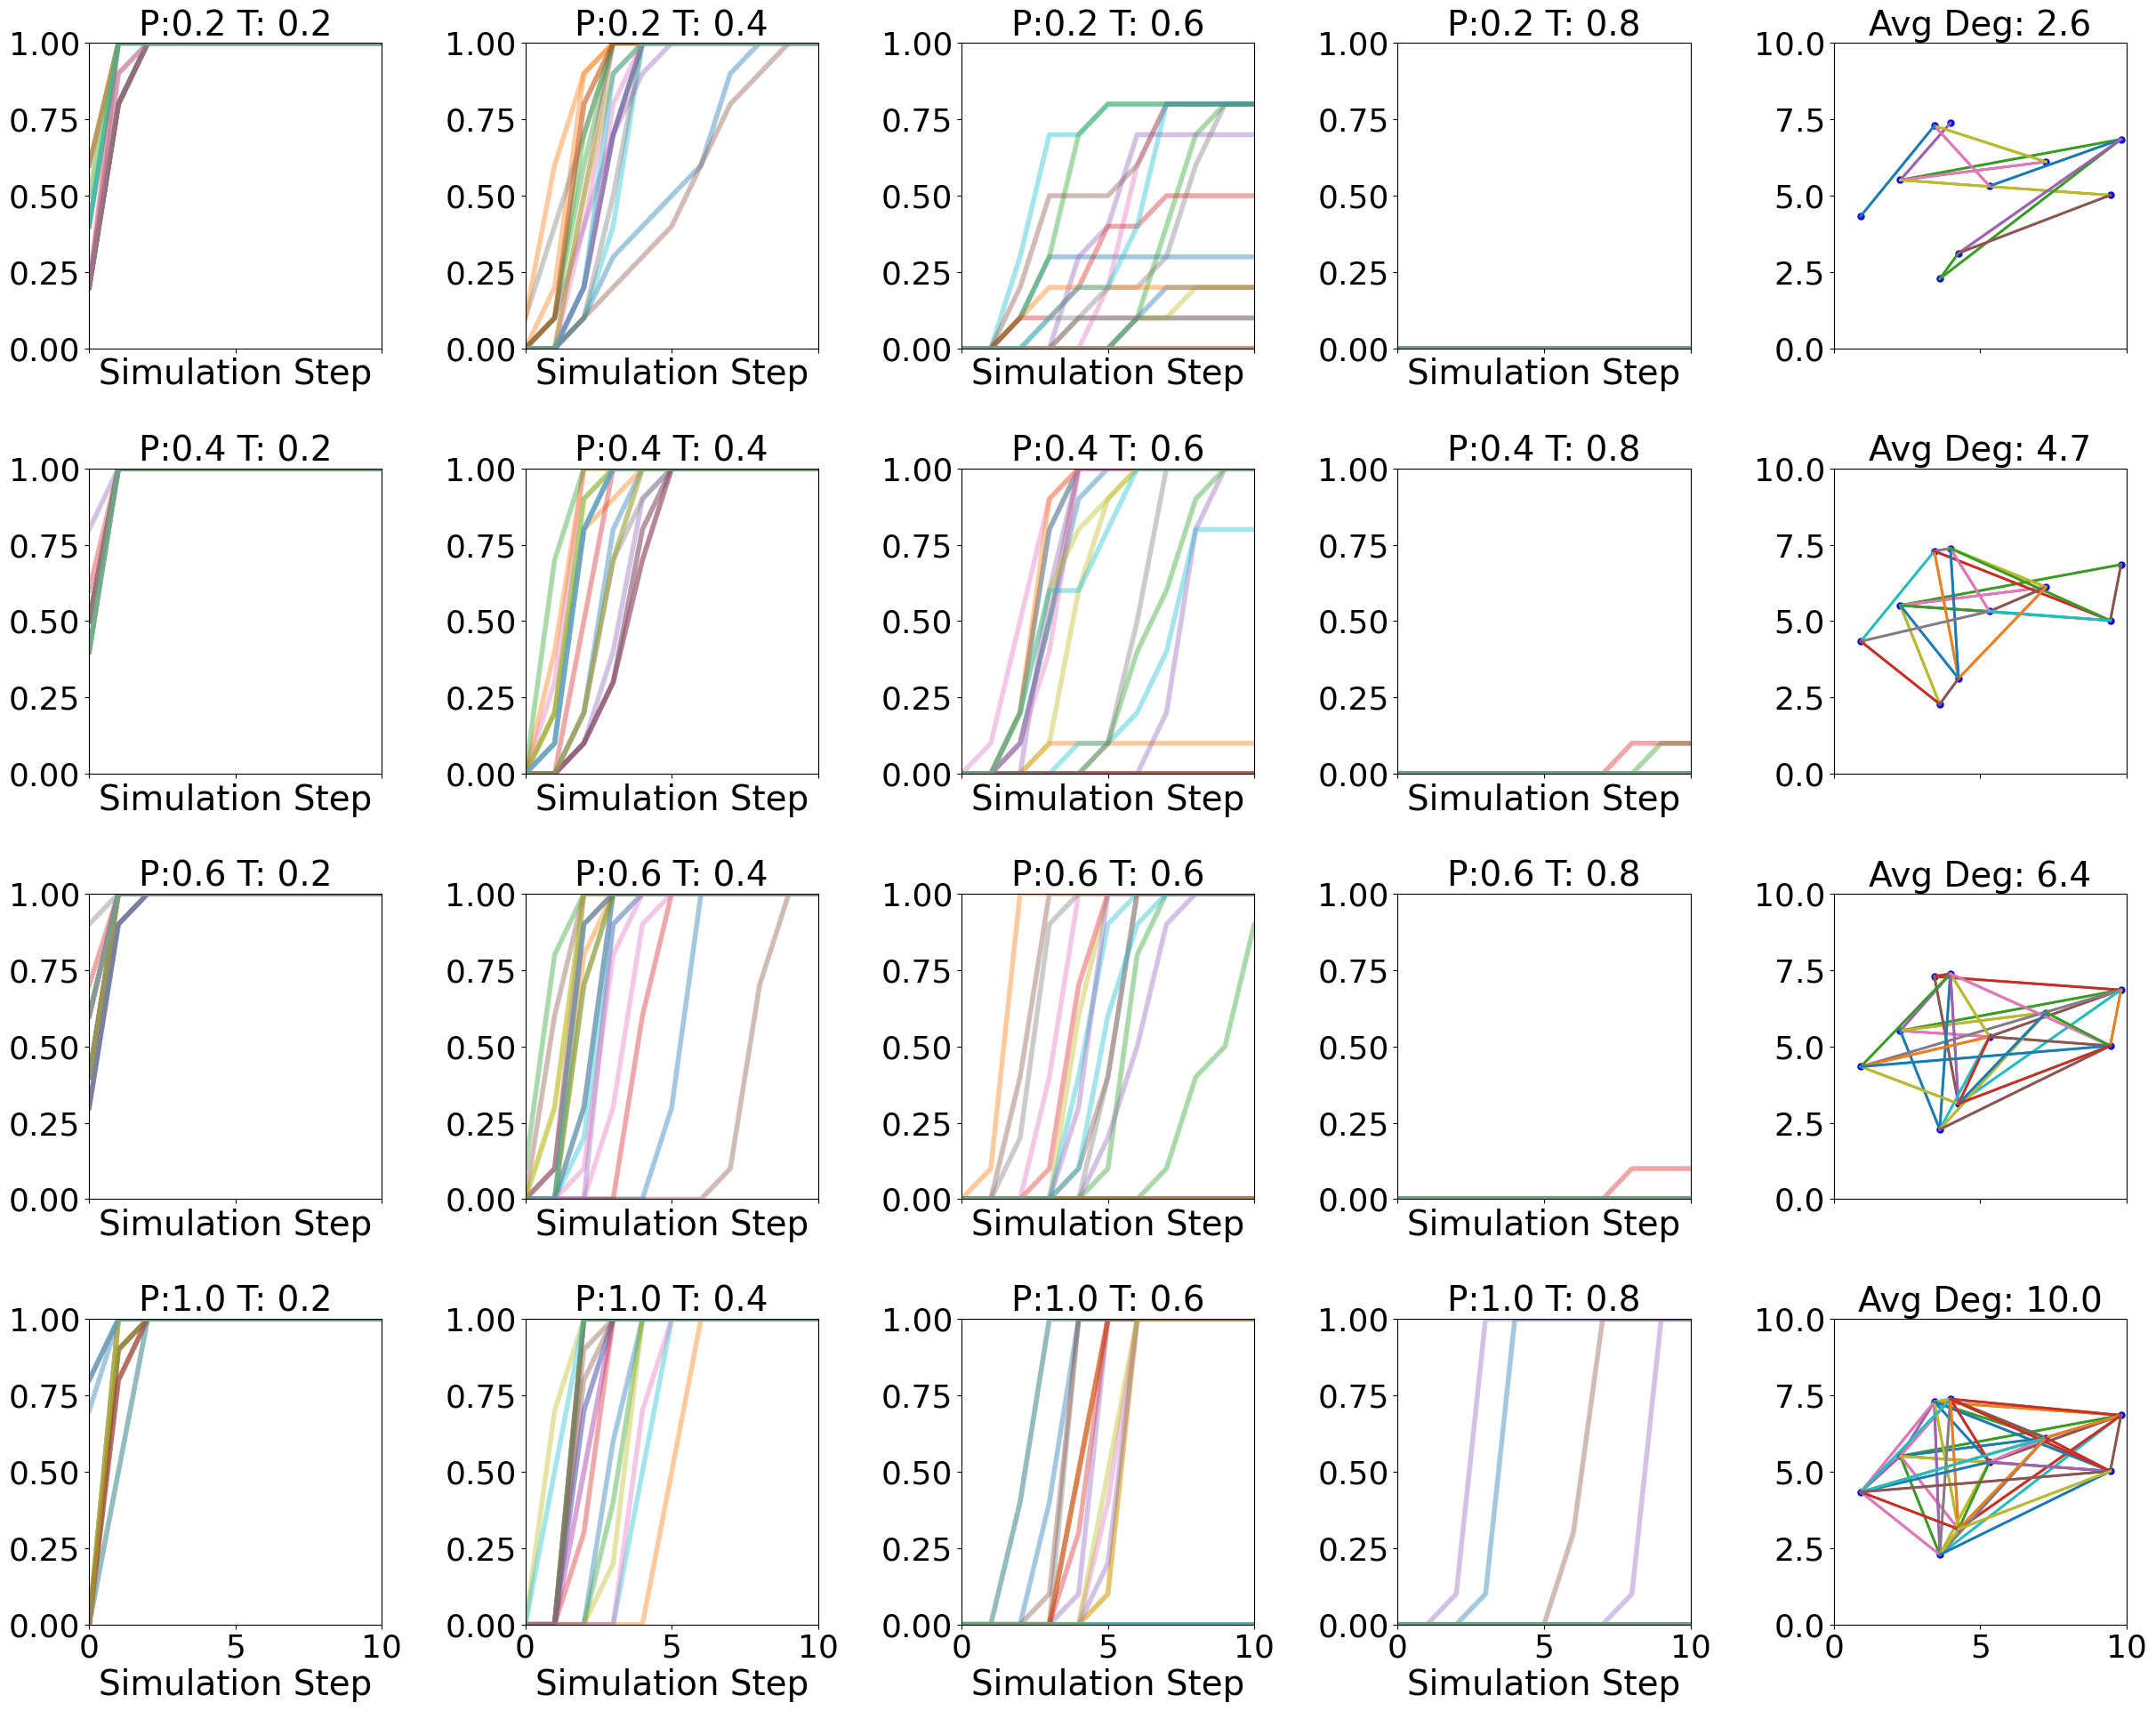

In [26]:
import random
import networkx as nx

random.seed(123)
np.random.seed(42)

#P = 2 #from 1 to 10??

all_neighbors = []

def calc_average_degree(num_agents):
    agent_degrees = []
    for i in range(0,num_agents):
        agent_degrees.append(0)
    for i in range(len(all_neighbors)):
        agent_degrees[all_neighbors[i][0].id] = agent_degrees[all_neighbors[i][0].id]+1
        agent_degrees[all_neighbors[i][1].id] = agent_degrees[all_neighbors[i][1].id]+1
    ss = 0.0
    for i in range(0,num_agents):
        agent_degrees[i] = agent_degrees[i]/2
        ss = ss + agent_degrees[i]
    return ss/num_agents

def create_neighbors(agent_a,agent_b,P):
    #D = (agent_a.region).dis(agent_b.region)
    q = random.uniform(0,1)
    if q<=P:
        all_neighbors.append([agent_a,agent_b])
        if agent_a.id!=agent_b.id:
            all_neighbors.append([agent_b,agent_a])
    return


def isneighbor(agent_a,agent_b):
    return [agent_a,agent_b] in all_neighbors

# for a in RANDOM_AGENTS:
#     print(a,john,isneighbor(a,john))

THRESH = 3
SIM_TIME = 30
THETA = 0.9
#update_migration_from_peer

grid = 4

fig,ax = plt.subplots(grid,grid+1,figsize=(5*(grid+1),5*grid),sharex=True)


for pidx, P in enumerate([0.2,0.4,0.6,1.0]):
    
    all_neighbors = []
    
    for i in range(0,len(RANDOM_AGENTS)):
        for j in range(i,len(RANDOM_AGENTS)):
            create_neighbors(RANDOM_AGENTS[i],RANDOM_AGENTS[j],P)
    
    createplot(RANDOM_AGENTS,[],ax[pidx][grid])
    ax[pidx][grid].set_xlim([0,MAX_SCALE])
    ax[pidx][grid].set_ylim([0,MAX_SCALE])
    
    for i in range(0,len(all_neighbors)):
        ax[pidx][grid].plot([all_neighbors[i][0].region.x,all_neighbors[i][1].region.x],[all_neighbors[i][0].region.y,all_neighbors[i][1].region.y],linewidth=2)
    
    ax[pidx][grid].set(title='Avg Deg: '+str(calc_average_degree(NUM_AGENTS)))
    
    for tidx, THRESH in enumerate([0.2,0.4,0.6,0.8]):
        
        for scenario_idx in range(0,20):
            
            RANDOM_EVENTS = create_random_events(10)
        
            ts = []
            people_migrated = []

            for agent in RANDOM_AGENTS:
                agent.reset_agent()

            for t in range(0,SIM_TIME):

                #print("\nAt time ",t)
                for john in RANDOM_AGENTS:
                    cur_event_set = []
                    for e in RANDOM_EVENTS:
                        if e.happened(t):
                            cur_event_set.append(e)
                    risk = riskfunc(john,cur_event_set,DELTA)
                    john.update_fear(risk,THETA)

                neighbor_intentions = []
                neighbor_sizes = []
                ##synchronous, so everyone updates after interaction
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'before peer interaction')
                    neighbor_effect = 0
                    tot_neighbor = 1
                    for j in range(0,len(RANDOM_AGENTS)):
                        if i==j:
                            continue
                        next_agent = RANDOM_AGENTS[j]
                        if isneighbor(cur_agent,next_agent):
                            neighbor_effect = neighbor_effect+max(next_agent.intention,next_agent.migration)
                            tot_neighbor = tot_neighbor + 1
                    neighbor_intentions.append(neighbor_effect)
                    neighbor_sizes.append(tot_neighbor)

                ##update
                #print('')
                migrated = 0
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    cur_agent.update_migration_from_peer(neighbor_intentions[i]/neighbor_sizes[i],THRESH)
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'after peer interaction')
                    migrated = migrated + cur_agent.migration

                ts.append(t)
                people_migrated.append(migrated)

            #print(len(ts))
            #print(len(ps))
            #print(len(ts),len(people_migrated),pidx,tidx)
            for i in range(len(people_migrated)):
                people_migrated[i] = people_migrated[i]/len(RANDOM_AGENTS)
            ax[pidx][tidx].plot(ts,people_migrated,linewidth=4,alpha=0.4)
            ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            ax[pidx][tidx].set_xlabel('Simulation Step')
            ax[pidx][tidx].set_ylim([0,1])
            ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=2)
            # ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,None])
            # ax[pidx][tidx].set_xlim([0,None])
    #nx.draw(G,ax=ax[pidx][grid])
fig.tight_layout()
plt.show()

In [27]:
# A graph G(n,P) where each vertex can have a triggering effect of q at each time t. (q~Bern(Q))
# Vertex can have either state 0/1
# V(t) = 1, if V(t-1) = 1
# V(t) = 1, if \sum U(t-1) + Q(t-1) >= T 
# V(t) = 0, otherwise


<!-- Keep n fixed construct a curve
that shows for each different p, 
x axis t
y axis percentage of people migrating -->

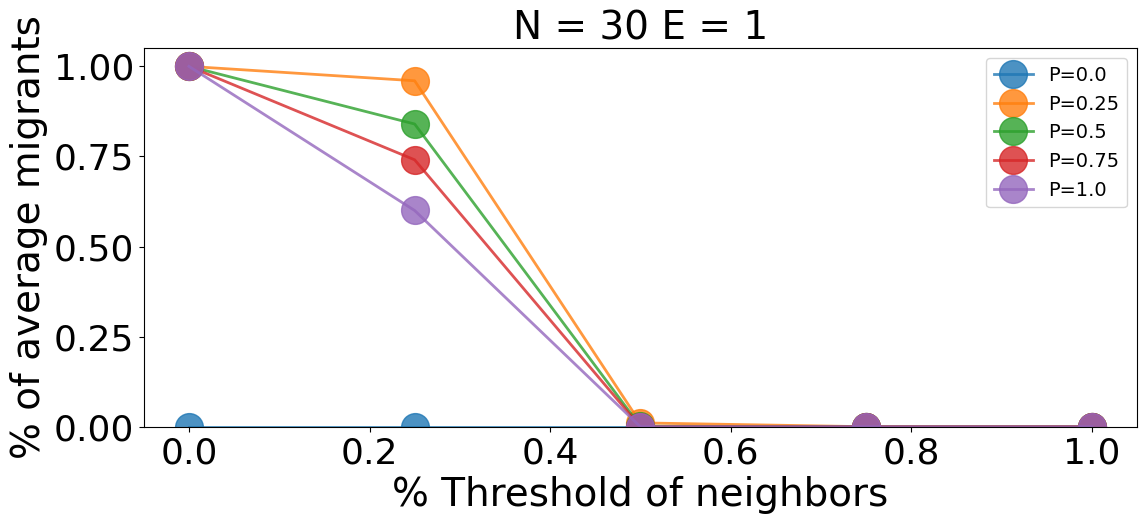

CPU times: user 2min 33s, sys: 14.8 ms, total: 2min 33s
Wall time: 2min 37s


In [52]:
%%time
import random
import networkx as nx

random.seed(123)
np.random.seed(42)

all_neighbors = []

def calc_average_degree(num_agents):
    agent_degrees = []
    for i in range(0,num_agents):
        agent_degrees.append(0)
    for i in range(len(all_neighbors)):
        agent_degrees[all_neighbors[i][0].id] = agent_degrees[all_neighbors[i][0].id]+1
        agent_degrees[all_neighbors[i][1].id] = agent_degrees[all_neighbors[i][1].id]+1
    ss = 0.0
    for i in range(0,num_agents):
        agent_degrees[i] = agent_degrees[i]/2
        ss = ss + agent_degrees[i]
    return ss/num_agents

def create_neighbors(agent_a,agent_b,P):
    #D = (agent_a.region).dis(agent_b.region)
    q = random.uniform(0,1)
    if q<=P:
        all_neighbors.append([agent_a,agent_b])
        if agent_a.id!=agent_b.id:
            all_neighbors.append([agent_b,agent_a])
    return


def isneighbor(agent_a,agent_b):
    return [agent_a,agent_b] in all_neighbors

# for a in RANDOM_AGENTS:
#     print(a,john,isneighbor(a,john))

PSPACE = 5
TSPACE = 5
DELTA = 2
TOT_SCENARIO = 50
NUM_AGENTS = 30
NUM_EVENTS = 1
SIM_TIME = 30
THETA = 0.9
#update_migration_from_peer

grid = 4

#fig,ax = plt.subplots(grid,grid+1,figsize=(5*(grid+1),5*grid),sharex=True)
fig,ax = plt.subplots(figsize=(12,6))

for P in np.linspace(0,1,PSPACE):
    
    xs = []
    ys = []
    
    for THRESH in np.linspace(0,1,TSPACE):
        
        xs.append(THRESH)
        tot_migrant_percent = 0.0
        
        #TOT_SCENARIO = 30
        # how is each scenario defined?
        # a set of events at different locations
        # a set of agents at different locations
        # so we need to create agents and events in each scenario
        for scenario_idx in range(0,TOT_SCENARIO):
            
            #create events
            RANDOM_EVENTS = create_random_events(NUM_EVENTS)
            
            #create agents and neighborhood
            RANDOM_AGENTS = create_random_agents(NUM_AGENTS)
            all_neighbors = []
    
            for i in range(0,len(RANDOM_AGENTS)):
                for j in range(i,len(RANDOM_AGENTS)):
                    create_neighbors(RANDOM_AGENTS[i],RANDOM_AGENTS[j],P)
        
            ts = []
            people_migrated = []

            for agent in RANDOM_AGENTS:
                agent.reset_agent()

            for t in range(0,SIM_TIME):

                #print("\nAt time ",t)
                for john in RANDOM_AGENTS:
                    cur_event_set = []
                    for e in RANDOM_EVENTS:
                        if e.happened(t):
                            cur_event_set.append(e)
                    risk = riskfunc(john,cur_event_set,DELTA)
                    john.update_fear(risk,THETA)

                neighbor_intentions = []
                neighbor_sizes = []
                ##synchronous, so everyone updates after interaction
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'before peer interaction')
                    neighbor_effect = 0
                    tot_neighbor = 1
                    for j in range(0,len(RANDOM_AGENTS)):
                        if i==j:
                            continue
                        next_agent = RANDOM_AGENTS[j]
                        if isneighbor(cur_agent,next_agent):
                            neighbor_effect = neighbor_effect+max(next_agent.intention,next_agent.migration)
                            tot_neighbor = tot_neighbor + 1
                    neighbor_intentions.append(neighbor_effect)
                    neighbor_sizes.append(tot_neighbor)

                ##update
                #print('')
                migrated = 0
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    cur_agent.update_migration_from_peer(neighbor_intentions[i]/neighbor_sizes[i],THRESH)
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'after peer interaction')
                    migrated = migrated + cur_agent.migration

                ts.append(t)
                people_migrated.append(migrated)

            #print(len(ts))
            #print(len(ps))
            #print(len(ts),len(people_migrated),pidx,tidx)
            for i in range(len(people_migrated)):
                people_migrated[i] = people_migrated[i]/len(RANDOM_AGENTS)
            
            tot_migrant_percent = tot_migrant_percent + people_migrated[-1]
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=4,alpha=0.4)
            # ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,1])
            # ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=2)
            # ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,None])
            # ax[pidx][tidx].set_xlim([0,None])
        tot_migrant_percent = tot_migrant_percent/TOT_SCENARIO
        ys.append(tot_migrant_percent)
    #nx.draw(G,ax=ax[pidx][grid])
    ax.plot(xs,ys,label='P='+str(round(P,2)),linewidth=2,marker='o',markersize=20,alpha=0.8)
ax.set_xlabel('% Threshold of neighbors')
ax.set_ylim([-0.0,1.05])
ax.set_ylabel('% of average migrants')
ax.set_title('N = '+str(NUM_AGENTS)+' E = '+str(NUM_EVENTS))
ax.legend(loc='best',fontsize=14)
fig.tight_layout()
plt.show()

In [ ]:
30 scenario , 30 sim time , 10 p, 10 t, 10 agents, 10 events -- 10 s
40 scenario , 30 sim time , 10 p, 10 t, 10 agents, 10 events -- 14 s

In [ ]:
# more samples of graph is necessary
# vertices along circumference of circle
# events along some axis restrained

In [36]:
NUM_AGENTS = 50
RANDOM_AGENTS = []
np.random.seed(123)
for i in range(0,NUM_AGENTS):
    cur_id = i
    rand_loc = np.random.rand(1,2).flatten()
    agent_rand_loc = np.random.rand(1,2).flatten()
    agent_r = Region(agent_rand_loc[0]*MAX_SCALE,agent_rand_loc[1]*MAX_SCALE)
    john = Agent(cur_id, agent_r,1)
    RANDOM_AGENTS.append(john)

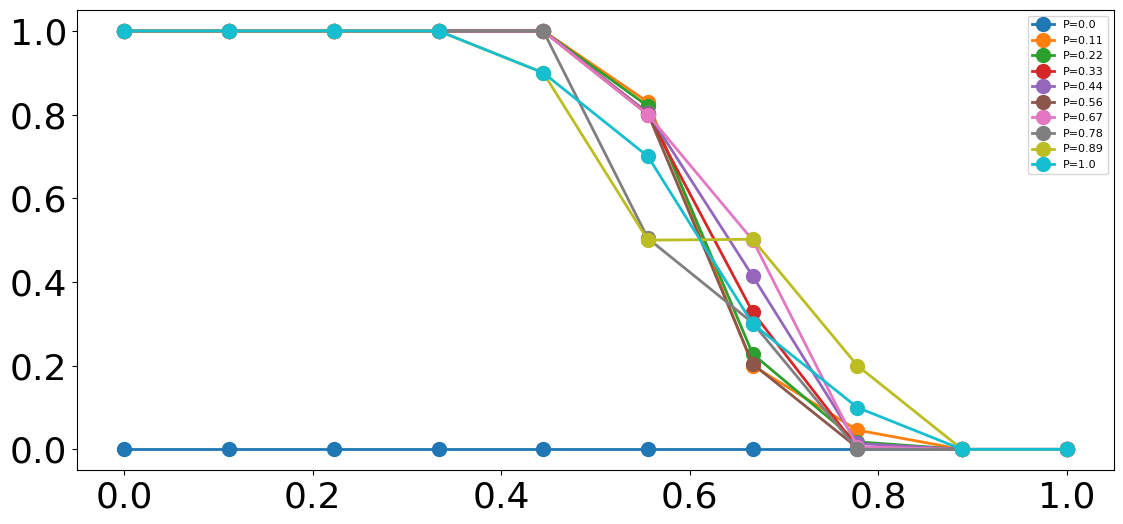

CPU times: user 18min 5s, sys: 41.7 ms, total: 18min 5s
Wall time: 18min 27s


In [38]:
%%time

import random
import networkx as nx

random.seed(123)
np.random.seed(42)

#P = 2 #from 1 to 10??

all_neighbors = []

def calc_average_degree(num_agents):
    agent_degrees = []
    for i in range(0,num_agents):
        agent_degrees.append(0)
    for i in range(len(all_neighbors)):
        agent_degrees[all_neighbors[i][0].id] = agent_degrees[all_neighbors[i][0].id]+1
        agent_degrees[all_neighbors[i][1].id] = agent_degrees[all_neighbors[i][1].id]+1
    ss = 0.0
    for i in range(0,num_agents):
        agent_degrees[i] = agent_degrees[i]/2
        ss = ss + agent_degrees[i]
    return ss/num_agents

def create_neighbors(agent_a,agent_b,P):
    #D = (agent_a.region).dis(agent_b.region)
    q = random.uniform(0,1)
    if q<=P:
        all_neighbors.append([agent_a,agent_b])
        if agent_a.id!=agent_b.id:
            all_neighbors.append([agent_b,agent_a])
    return


def isneighbor(agent_a,agent_b):
    return [agent_a,agent_b] in all_neighbors

# for a in RANDOM_AGENTS:
#     print(a,john,isneighbor(a,john))

THRESH = 3
SIM_TIME = 30
THETA = 0.9
#update_migration_from_peer

grid = 4

#fig,ax = plt.subplots(grid,grid+1,figsize=(5*(grid+1),5*grid),sharex=True)
fig,ax = plt.subplots(figsize=(12,6))

for P in np.linspace(0,1,10):
    
    all_neighbors = []
    
    for i in range(0,len(RANDOM_AGENTS)):
        for j in range(i,len(RANDOM_AGENTS)):
            create_neighbors(RANDOM_AGENTS[i],RANDOM_AGENTS[j],P)
    
    #createplot(RANDOM_AGENTS,[],ax[pidx][grid])
    #ax[pidx][grid].set_xlim([0,MAX_SCALE])
    #ax[pidx][grid].set_ylim([0,MAX_SCALE])
    
    #for i in range(0,len(all_neighbors)):
    #    ax[pidx][grid].plot([all_neighbors[i][0].region.x,all_neighbors[i][1].region.x],[all_neighbors[i][0].region.y,all_neighbors[i][1].region.y],linewidth=2)
    
    #ax[pidx][grid].set(title='Avg Deg: '+str(calc_average_degree(NUM_AGENTS)))
    
    xs = []
    ys = []
    
    for THRESH in np.linspace(0,1,10):
        
        xs.append(THRESH)
        tot_migrant_percent = 0.0
        
        TOT_SCENARIO = 10
        for scenario_idx in range(0,TOT_SCENARIO):
            
            RANDOM_EVENTS = create_random_events(10)
        
            ts = []
            people_migrated = []

            for agent in RANDOM_AGENTS:
                agent.reset_agent()

            for t in range(0,SIM_TIME):

                #print("\nAt time ",t)
                for john in RANDOM_AGENTS:
                    cur_event_set = []
                    for e in RANDOM_EVENTS:
                        if e.happened(t):
                            cur_event_set.append(e)
                    risk = riskfunc(john,cur_event_set,DELTA)
                    john.update_fear(risk,THETA)

                neighbor_intentions = []
                neighbor_sizes = []
                ##synchronous, so everyone updates after interaction
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'before peer interaction')
                    neighbor_effect = 0
                    tot_neighbor = 1
                    for j in range(0,len(RANDOM_AGENTS)):
                        if i==j:
                            continue
                        next_agent = RANDOM_AGENTS[j]
                        if isneighbor(cur_agent,next_agent):
                            neighbor_effect = neighbor_effect+max(next_agent.intention,next_agent.migration)
                            tot_neighbor = tot_neighbor + 1
                    neighbor_intentions.append(neighbor_effect)
                    neighbor_sizes.append(tot_neighbor)

                ##update
                #print('')
                migrated = 0
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    cur_agent.update_migration_from_peer(neighbor_intentions[i]/neighbor_sizes[i],THRESH)
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'after peer interaction')
                    migrated = migrated + cur_agent.migration

                ts.append(t)
                people_migrated.append(migrated)

            #print(len(ts))
            #print(len(ps))
            #print(len(ts),len(people_migrated),pidx,tidx)
            for i in range(len(people_migrated)):
                people_migrated[i] = people_migrated[i]/len(RANDOM_AGENTS)
            
            tot_migrant_percent = tot_migrant_percent + people_migrated[-1]
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=4,alpha=0.4)
            # ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,1])
            # ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=2)
            # ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,None])
            # ax[pidx][tidx].set_xlim([0,None])
        tot_migrant_percent = tot_migrant_percent/TOT_SCENARIO
        ys.append(tot_migrant_percent)
    #nx.draw(G,ax=ax[pidx][grid])
    ax.plot(xs,ys,label='P='+str(round(P,2)),linewidth=2,marker='o',markersize=10)
ax.legend(loc='best',fontsize=8)
fig.tight_layout()
plt.show()

In [ ]:
%%time

import random
import networkx as nx

random.seed(123)
np.random.seed(42)

#P = 2 #from 1 to 10??

all_neighbors = []

def calc_average_degree(num_agents):
    agent_degrees = []
    for i in range(0,num_agents):
        agent_degrees.append(0)
    for i in range(len(all_neighbors)):
        agent_degrees[all_neighbors[i][0].id] = agent_degrees[all_neighbors[i][0].id]+1
        agent_degrees[all_neighbors[i][1].id] = agent_degrees[all_neighbors[i][1].id]+1
    ss = 0.0
    for i in range(0,num_agents):
        agent_degrees[i] = agent_degrees[i]/2
        ss = ss + agent_degrees[i]
    return ss/num_agents

def create_neighbors(agent_a,agent_b,P):
    #D = (agent_a.region).dis(agent_b.region)
    q = random.uniform(0,1)
    if q<=P:
        all_neighbors.append([agent_a,agent_b])
        if agent_a.id!=agent_b.id:
            all_neighbors.append([agent_b,agent_a])
    return


def isneighbor(agent_a,agent_b):
    return [agent_a,agent_b] in all_neighbors

# for a in RANDOM_AGENTS:
#     print(a,john,isneighbor(a,john))

THRESH = 3
SIM_TIME = 30
THETA = 0.9
#update_migration_from_peer

grid = 4

#fig,ax = plt.subplots(grid,grid+1,figsize=(5*(grid+1),5*grid),sharex=True)
fig,ax = plt.subplots(figsize=(12,6))

for P in np.linspace(0,1,10):
    
    all_neighbors = []
    
    for i in range(0,len(RANDOM_AGENTS)):
        for j in range(i,len(RANDOM_AGENTS)):
            create_neighbors(RANDOM_AGENTS[i],RANDOM_AGENTS[j],P)
    
    #createplot(RANDOM_AGENTS,[],ax[pidx][grid])
    #ax[pidx][grid].set_xlim([0,MAX_SCALE])
    #ax[pidx][grid].set_ylim([0,MAX_SCALE])
    
    #for i in range(0,len(all_neighbors)):
    #    ax[pidx][grid].plot([all_neighbors[i][0].region.x,all_neighbors[i][1].region.x],[all_neighbors[i][0].region.y,all_neighbors[i][1].region.y],linewidth=2)
    
    #ax[pidx][grid].set(title='Avg Deg: '+str(calc_average_degree(NUM_AGENTS)))
    
    xs = []
    ys = []
    
    for THRESH in np.linspace(0,1,10):
        
        xs.append(THRESH)
        tot_migrant_percent = 0.0
        
        TOT_SCENARIO = 50
        for scenario_idx in range(0,TOT_SCENARIO):
            
            RANDOM_EVENTS = create_random_events(10)
        
            ts = []
            people_migrated = []

            for agent in RANDOM_AGENTS:
                agent.reset_agent()

            for t in range(0,SIM_TIME):

                #print("\nAt time ",t)
                for john in RANDOM_AGENTS:
                    cur_event_set = []
                    for e in RANDOM_EVENTS:
                        if e.happened(t):
                            cur_event_set.append(e)
                    risk = riskfunc(john,cur_event_set,DELTA)
                    john.update_fear(risk,THETA)

                neighbor_intentions = []
                neighbor_sizes = []
                ##synchronous, so everyone updates after interaction
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'before peer interaction')
                    neighbor_effect = 0
                    tot_neighbor = 1
                    for j in range(0,len(RANDOM_AGENTS)):
                        if i==j:
                            continue
                        next_agent = RANDOM_AGENTS[j]
                        if isneighbor(cur_agent,next_agent):
                            neighbor_effect = neighbor_effect+max(next_agent.intention,next_agent.migration)
                            tot_neighbor = tot_neighbor + 1
                    neighbor_intentions.append(neighbor_effect)
                    neighbor_sizes.append(tot_neighbor)

                ##update
                #print('')
                migrated = 0
                for i in range(0,len(RANDOM_AGENTS)):
                    cur_agent = RANDOM_AGENTS[i]
                    cur_agent.update_migration_from_peer(neighbor_intentions[i]/neighbor_sizes[i],THRESH)
                    #print('agent',cur_agent.id,'has intention:',cur_agent.intention,'migration:',cur_agent.migration,'after peer interaction')
                    migrated = migrated + cur_agent.migration

                ts.append(t)
                people_migrated.append(migrated)

            #print(len(ts))
            #print(len(ps))
            #print(len(ts),len(people_migrated),pidx,tidx)
            for i in range(len(people_migrated)):
                people_migrated[i] = people_migrated[i]/len(RANDOM_AGENTS)
            
            tot_migrant_percent = tot_migrant_percent + people_migrated[-1]
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=4,alpha=0.4)
            # ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,1])
            # ax[pidx][tidx].set_xlim([0,None])
            # ax[pidx][tidx].plot(ts,people_migrated,linewidth=2)
            # ax[pidx][tidx].set(title='P:'+str(P)+" T: "+str(THRESH))
            # ax[pidx][tidx].set_xlabel('Simulation Step')
            # ax[pidx][tidx].set_ylim([0,None])
            # ax[pidx][tidx].set_xlim([0,None])
        tot_migrant_percent = tot_migrant_percent/TOT_SCENARIO
        ys.append(tot_migrant_percent)
    #nx.draw(G,ax=ax[pidx][grid])
    ax.plot(xs,ys,label='P='+str(round(P,2)),linewidth=2,marker='o',markersize=10)
ax.legend(loc='best',fontsize=8)
fig.tight_layout()
plt.show()